# Part A : Audio to English Transcription

In [4]:
import warnings
warnings.filterwarnings("ignore")

!pip install -qq torch numpy pandas matplotlib seaborn librosa openai-whisper pydub nltk wordcloud tqdm plotly
!pip install -qq indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.8 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.4 MB/s eta 0:00:00


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import torch
import whisper
import datetime
import re
import nltk
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from pydub import AudioSegment
from pydub.silence import split_on_silence
from tqdm import tqdm
import json
import plotly.express as px
import plotly.graph_objects as go
import pickle
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from indicnlp.normalize import indic_normalize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.metrics import edit_distance

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
class AudioTranscriptionPipeline:
    def __init__(self, audio_path, output_dir="output", model_size="large-v3", manual_transcript_path=None):
        self.audio_path = audio_path
        self.output_dir = output_dir
        self.model_size = model_size
        self.segments_dir = os.path.join(output_dir, "segments")
        self.checkpoint_dir = os.path.join(output_dir, "checkpoints")
        self.filler_words = ['ahh', 'like', 'right', 'uhh', 'uhhh', 'um', 'uh', 'hmm', 'er', 'mm']
        self.manual_transcript_path = manual_transcript_path
        
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.segments_dir, exist_ok=True)
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        
        self.segments_metadata = []
        self.transcription_results = []
        self.cleaned_transcription_results = []
        self.language_distribution = {}
        
        self.segments_checkpoint = os.path.join(self.checkpoint_dir, "segments_metadata.pkl")
        self.transcription_checkpoint = os.path.join(self.checkpoint_dir, "transcription_results.pkl")
        self.cleaned_checkpoint = os.path.join(self.checkpoint_dir, "cleaned_results.pkl")
        self.language_checkpoint = os.path.join(self.checkpoint_dir, "language_distribution.pkl")
        self.df_checkpoint = os.path.join(self.checkpoint_dir, "processed_df.pkl")
        self.metrics_checkpoint = os.path.join(self.checkpoint_dir, "comparison_metrics.pkl")
        
    def load_model(self):
        print(f"Loading Whisper {self.model_size} model...")
        self.model = whisper.load_model(self.model_size)
        print("Model loaded successfully")
        
    def load_and_segment_audio(self, min_segment_length=15000, max_segment_length=30000, 
                               silence_thresh=-40, min_silence_len=700, force_reprocess=False):

        if os.path.exists(self.segments_checkpoint) and not force_reprocess:
            print(f"Loading segments from checkpoint: {self.segments_checkpoint}")
            with open(self.segments_checkpoint, 'rb') as f:
                self.segments_metadata = pickle.load(f)
            
            segment_paths = [metadata["path"] for metadata in self.segments_metadata]
            
            missing_segments = [path for path in segment_paths if not os.path.exists(path)]
            
            if missing_segments:
                print(f"Found {len(missing_segments)} missing segment files. Regenerating segments...")
            else:
                print(f"Loaded {len(segment_paths)} segments from checkpoint")
                return segment_paths
        
        print(f"Loading audio file: {self.audio_path}")
        audio = AudioSegment.from_file(self.audio_path)
        
        print("Segmenting audio based on silence...")
        chunks = split_on_silence(
            audio,
            min_silence_len=min_silence_len,
            silence_thresh=silence_thresh,
            keep_silence=500  
        )
        
        print("Processing segments to ensure optimal length...")
        final_chunks = []
        
        for i, chunk in enumerate(chunks):
            if len(chunk) < min_segment_length:
                if i < len(chunks) - 1:
                    chunks[i+1] = chunk + chunks[i+1]
                else:
                    final_chunks.append(chunk)
            elif len(chunk) > max_segment_length:
                segment_count = len(chunk) // max_segment_length + 1
                segment_size = len(chunk) // segment_count
                
                for j in range(segment_count):
                    start = j * segment_size
                    end = (j + 1) * segment_size if j < segment_count - 1 else len(chunk)
                    final_chunks.append(chunk[start:end])
            else:
                final_chunks.append(chunk)
        
        segment_paths = []
        self.segments_metadata = []  
        
        print(f"Saving {len(final_chunks)} segments...")
        for i, chunk in enumerate(final_chunks):
            segment_path = os.path.join(self.segments_dir, f"segment_{i:03d}.wav")
            chunk.export(segment_path, format="wav")
            
            self.segments_metadata.append({
                "segment_id": i,
                "path": segment_path,
                "duration_sec": len(chunk) / 1000,
                "start_time": sum([len(c) for c in final_chunks[:i]]) / 1000
            })
            
            segment_paths.append(segment_path)
        
        with open(self.segments_checkpoint, 'wb') as f:
            pickle.dump(self.segments_metadata, f)
            
        print(f"Created {len(segment_paths)} segments and saved checkpoint")
        return segment_paths
    
    def transcribe_segments(self, segment_paths, force_reprocess=False):
        if os.path.exists(self.transcription_checkpoint) and os.path.exists(self.language_checkpoint) and not force_reprocess:
            print(f"Loading transcriptions from checkpoint: {self.transcription_checkpoint}")
            with open(self.transcription_checkpoint, 'rb') as f:
                self.transcription_results = pickle.load(f)
            
            with open(self.language_checkpoint, 'rb') as f:
                self.language_distribution = pickle.load(f)
                
            print(f"Loaded {len(self.transcription_results)} transcriptions from checkpoint")
            return self.transcription_results
            
        print("Starting transcription process...")
        
        if not hasattr(self, 'model'):
            self.load_model()
        
        self.transcription_results = []  
        self.language_distribution = {}  
        for i, segment_path in enumerate(tqdm(segment_paths, desc="Transcribing segments")):
            
            result = self.model.transcribe(
                segment_path,
                language=None,  
                task="transcribe",
                verbose=False
            )
            
            result["segment_id"] = i
            result["segment_path"] = segment_path
            result["start_time"] = self.segments_metadata[i]["start_time"]
            
            lang = result.get("language", "unknown")
            self.language_distribution[lang] = self.language_distribution.get(lang, 0) + 1
            
            self.transcription_results.append(result)
            
            if (i + 1) % 5 == 0 or i == len(segment_paths) - 1:
                with open(self.transcription_checkpoint, 'wb') as f:
                    pickle.dump(self.transcription_results, f)
                
                with open(self.language_checkpoint, 'wb') as f:
                    pickle.dump(self.language_distribution, f)
        
        print("Transcription completed successfully")
        return self.transcription_results
    
    def process_transcriptions(self, force_reprocess=False):
        if os.path.exists(self.cleaned_checkpoint) and os.path.exists(self.df_checkpoint) and not force_reprocess:
            print(f"Loading processed transcriptions from checkpoint: {self.cleaned_checkpoint}")
            with open(self.cleaned_checkpoint, 'rb') as f:
                self.cleaned_transcription_results = pickle.load(f)
            
            with open(self.df_checkpoint, 'rb') as f:
                df = pickle.load(f)
                
            print(f"Loaded {len(self.cleaned_transcription_results)} processed transcriptions from checkpoint")
            return df
            
        print("Processing transcriptions...")
        
        if not self.transcription_results:
            raise ValueError("No transcription results to process. Run transcribe_segments first.")
        
        self.cleaned_transcription_results = []  
        
        for result in self.transcription_results:
            for segment in result["segments"]:
                absolute_start = result["start_time"] + segment["start"]
                absolute_end = result["start_time"] + segment["end"]
                
                start_time = str(datetime.timedelta(seconds=int(absolute_start)))
                end_time = str(datetime.timedelta(seconds=int(absolute_end)))
                
                original_text = segment["text"].strip()
                
                # First remove filler words
                cleaned_text = self._remove_filler_words(original_text)
                
                # Then remove consecutive repeats
                cleaned_text = self._remove_consecutive_repeats(cleaned_text)
                
                filler_count = self._count_filler_words(original_text)
                
                self.cleaned_transcription_results.append({
                    "segment_id": result["segment_id"],
                    "start_time": start_time,
                    "end_time": end_time,
                    "start_seconds": absolute_start,
                    "end_seconds": absolute_end,
                    "duration": segment["end"] - segment["start"],
                    "language": result.get("language", "unknown"),
                    "original_text": original_text,
                    "cleaned_text": cleaned_text,
                    "filler_word_count": filler_count
                })
        
        df = pd.DataFrame(self.cleaned_transcription_results)
        
        csv_path = os.path.join(self.output_dir, "transcription_results.csv")
        df.to_csv(csv_path, index=False)
        
        with open(self.cleaned_checkpoint, 'wb') as f:
            pickle.dump(self.cleaned_transcription_results, f)
            
        with open(self.df_checkpoint, 'wb') as f:
            pickle.dump(df, f)
            
        print(f"Processed transcriptions saved to {csv_path} and checkpoint")
        
        return df
    
    def _remove_filler_words(self, text):
        tokens = word_tokenize(text.lower())
        
        filtered_tokens = [token for token in tokens if token.lower() not in self.filler_words]
        cleaned_text = ' '.join(filtered_tokens)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        
        return cleaned_text
    
    def _count_filler_words(self, text):
        count = 0
        tokens = word_tokenize(text.lower())
        
        for token in tokens:
            if token.lower() in self.filler_words:
                count += 1
                
        return count
    
    def generate_full_transcript(self, df):
        transcript_path = os.path.join(self.output_dir, "original_transcript.txt")
        cleaned_transcript_path = os.path.join(self.output_dir, "cleaned_transcript.txt")
        
        if os.path.exists(transcript_path) and os.path.exists(cleaned_transcript_path):
            print("Transcripts already exist, skipping generation")
            with open(transcript_path, "r", encoding="utf-8") as f:
                original_transcript = f.read()
            
            with open(cleaned_transcript_path, "r", encoding="utf-8") as f:
                cleaned_transcript = f.read()
                
            return original_transcript, cleaned_transcript
        
        print("Generating full transcripts...")
        
        df = df.sort_values(by="start_seconds")
        # Remove the timestamp formatting
        original_transcript = "\n".join([
            row['original_text']  # Just the text without timestamps
            for _, row in df.iterrows()
        ])
        
        cleaned_transcript = "\n".join([
            row['cleaned_text']  # Just the text without timestamps
            for _, row in df.iterrows()
        ])
        
        with open(transcript_path, "w", encoding="utf-8") as f:
            f.write(original_transcript)
            
        with open(cleaned_transcript_path, "w", encoding="utf-8") as f:
            f.write(cleaned_transcript)
            
        print("Transcripts saved successfully")
        return original_transcript, cleaned_transcript
    
    def compare_with_manual_transcript(self, df):
        if not self.manual_transcript_path or not os.path.exists(self.manual_transcript_path):
            print("Manual transcript not provided or does not exist. Skipping comparison.")
            return None
            
        print("Comparing with manual transcript...")
        
        try:
            with open(self.manual_transcript_path, 'r', encoding='utf-8') as f:
                manual_transcript = f.read()
                
            transcript_path = os.path.join(self.output_dir, "cleaned_transcript.txt")
            with open(transcript_path, 'r', encoding='utf-8') as f:
                auto_transcript = f.read()
                
            auto_cleaned = ""
            for line in auto_transcript.split('\n'):
                cleaned_line = re.sub(r'\[\d+:\d+:\d+ - \d+:\d+:\d+\] ', '', line)
                auto_cleaned += cleaned_line + ' '
            
            print("Tokenizing transcripts...")
            
            def chunk_tokenize(text, chunk_size=10000):
                tokens = []
                for i in range(0, len(text), chunk_size):
                    chunk = text[i:i+chunk_size]
                    chunk_tokens = word_tokenize(chunk.lower())
                    tokens.extend(chunk_tokens)
                    import gc
                    gc.collect()
                return tokens
                
            print("Tokenizing auto transcript...")
            auto_tokens = chunk_tokenize(auto_cleaned)
            print(f"Auto transcript tokens: {len(auto_tokens)}")
            
            print("Tokenizing manual transcript...")
            manual_tokens = chunk_tokenize(manual_transcript)
            print(f"Manual transcript tokens: {len(manual_tokens)}")
            
            print("Calculating BLEU score...")
            try:
                smoothie = SmoothingFunction().method1
                sample_size = min(10000, len(auto_tokens), len(manual_tokens))
                bleu_score = sentence_bleu([manual_tokens[:sample_size]], auto_tokens[:sample_size], smoothing_function=smoothie)
            except Exception as e:
                print(f"Error calculating BLEU score: {e}")
                bleu_score = 0.0
            
            print("Calculating Word Error Rate...")
            try:
                sample_size = min(5000, len(manual_tokens), len(auto_tokens))
                distance = edit_distance(manual_tokens[:sample_size], auto_tokens[:sample_size])
                wer = distance / len(manual_tokens[:sample_size]) if manual_tokens else 1.0
            except Exception as e:
                print(f"Error calculating WER: {e}")
                wer = 1.0
            
            print("Calculating Character Error Rate...")
            try:
                sample_size = min(10000, len(manual_transcript), len(auto_cleaned))
                char_distance = edit_distance(auto_cleaned[:sample_size].lower(), manual_transcript[:sample_size].lower())
                cer = char_distance / len(manual_transcript[:sample_size]) if manual_transcript else 1.0
            except Exception as e:
                print(f"Error calculating CER: {e}")
                cer = 1.0
                
            auto_cleaned = None
            auto_transcript = None
            manual_transcript = None
            import gc
            gc.collect()
            
            metrics = {
                "bleu_score": bleu_score,
                "word_error_rate": wer,
                "character_error_rate": cer,
                "auto_word_count": len(auto_tokens),
                "manual_word_count": len(manual_tokens),
                "word_count_difference": len(auto_tokens) - len(manual_tokens)
            }
            
            auto_tokens = None
            manual_tokens = None
            gc.collect()
            
            with open(self.metrics_checkpoint, 'wb') as f:
                pickle.dump(metrics, f)
            
            metrics_path = os.path.join(self.output_dir, "comparison_metrics.json")
            with open(metrics_path, 'w') as f:
                json.dump(metrics, f, indent=4)
                
            viz_dir = os.path.join(self.output_dir, "visualizations")
            os.makedirs(viz_dir, exist_ok=True)
            
            plt.figure(figsize=(8, 5))
            metrics_df = pd.DataFrame({
                'Transcript': ['Auto', 'Manual'],
                'Word Count': [metrics['auto_word_count'], metrics['manual_word_count']]
            })
            plt.bar(metrics_df['Transcript'], metrics_df['Word Count'])
            plt.title('Word Count Comparison')
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, "word_count_comparison.png"), dpi=200, bbox_inches='tight')
            plt.close()
            
            plt.figure(figsize=(10, 5))
            metrics_labels = ['WER', 'CER', 'BLEU']
            metrics_values = [metrics['word_error_rate'], metrics['character_error_rate'], metrics['bleu_score']]
            plt.bar(metrics_labels, metrics_values)
            plt.ylabel('Score')
            plt.title('Transcript Comparison Metrics')
            plt.tight_layout()
            plt.savefig(os.path.join(viz_dir, "transcript_metrics.png"), dpi=200, bbox_inches='tight')
            plt.close()
            
            print("Comparison metrics:")
            print(f"BLEU Score: {metrics['bleu_score']:.4f}")
            print(f"Word Error Rate (WER): {metrics['word_error_rate']:.4f}")
            print(f"Character Error Rate (CER): {metrics['character_error_rate']:.4f}")
            print(f"Auto transcript word count: {metrics['auto_word_count']}")
            print(f"Manual transcript word count: {metrics['manual_word_count']}")
            
            return metrics
            
        except Exception as e:
            print(f"Error during transcript comparison: {str(e)}")
            print("Continuing with pipeline despite comparison error.")
            metrics = {
                "error": str(e),
                "completed": False
            }
            with open(self.metrics_checkpoint, 'wb') as f:
                pickle.dump(metrics, f)
            return None
            
    def _remove_consecutive_repeats(self, text, max_phrase_length=3):
        """
        Remove consecutive repeated phrases up to max_phrase_length words.
        E.g., "okay okay" -> "okay", "are you are you" -> "are you"
        """
        # Tokenize the text
        tokens = word_tokenize(text.lower())
        cleaned_tokens = []
        i = 0
        
        while i < len(tokens):
            # For each position, check phrases of length 1, 2, and 3
            repeat_found = False
            
            for phrase_len in range(1, min(max_phrase_length + 1, len(tokens) - i + 1)):
                # Extract current phrase
                current_phrase = tokens[i:i+phrase_len]
                
                # Check if there's enough tokens ahead to potentially contain a repeat
                if i + 2*phrase_len <= len(tokens):
                    next_phrase = tokens[i+phrase_len:i+2*phrase_len]
                    
                    # If phrases match, it's a repeat
                    if current_phrase == next_phrase:
                        cleaned_tokens.extend(current_phrase)
                        i += 2 * phrase_len  # Skip both phrases
                        repeat_found = True
                        break
            
            # If no repeat found, add current token and move forward
            if not repeat_found:
                cleaned_tokens.append(tokens[i])
                i += 1
        
        # Convert tokens back to text
        cleaned_text = ' '.join(cleaned_tokens)
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        
        return cleaned_text

    def generate_visualizations(self, df):
        viz_dir = os.path.join(self.output_dir, "visualizations")
        os.makedirs(viz_dir, exist_ok=True)
        
        viz_files = [
            "language_distribution.png", 
            "filler_words_over_time.png",
            "segment_duration_distribution.png", 
            "wordcloud.png",
            "filler_words_per_minute.png",
            "speech_pattern_analysis.html",
            "language_switching_timeline.png",
            "word_count_summary.png",
            "summary_statistics.json"
        ]
        
        all_exist = all(os.path.exists(os.path.join(viz_dir, file)) for file in viz_files)
        
        if all_exist:
            print("All visualizations already exist, loading and displaying them")
            self._display_existing_visualizations(viz_dir)
            return
        
        df = df.copy()
        
        print("Initial data types:")
        print(df.dtypes)
        
        numeric_columns = ['start_seconds', 'end_seconds', 'duration']
        
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        if 'word_count' not in df.columns:
            print("Creating word_count column from original_text")
            df['word_count'] = df['original_text'].apply(lambda x: len(word_tokenize(x)))
        
        df['word_count'] = pd.to_numeric(df['word_count'], errors='coerce')
        
        df.dropna(subset=['duration', 'word_count', 'start_seconds', 'end_seconds'], inplace=True)
        
        df['words_per_second'] = df['word_count'] / df['duration']
        df['minute'] = (df['start_seconds'] // 60).astype(int)
        
        print("Data types after conversion:")
        print(df.dtypes)
        print(f"Number of rows after cleaning: {len(df)}")
        
        plt.figure(figsize=(10, 6))
        languages = list(self.language_distribution.keys())
        counts = list(self.language_distribution.values())
        plt.pie(counts, labels=languages, autopct='%1.1f%%', startangle=90)
        plt.title('Language Distribution in Audio')
        plt.savefig(os.path.join(viz_dir, "language_distribution.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        plt.figure(figsize=(12, 6))
        plt.plot(df['start_seconds']/60.0, df['filler_word_count'], marker='o', linestyle='-')  
        plt.xlabel('Time (minutes)')
        plt.ylabel('Number of Filler Words')
        plt.title('Filler Words Usage Over Time')
        plt.grid(True, alpha=0.3)
        plt.savefig(os.path.join(viz_dir, "filler_words_over_time.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        plt.figure(figsize=(10, 6))
        sns.histplot(df['duration'], bins=20, kde=True)
        plt.xlabel('Segment Duration (seconds)')
        plt.ylabel('Frequency')
        plt.title('Distribution of Segment Durations')
        plt.savefig(os.path.join(viz_dir, "segment_duration_distribution.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        all_text = ' '.join(df['cleaned_text'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white', 
                            max_words=200, contour_width=3, contour_color='steelblue').generate(all_text)
        plt.figure(figsize=(16, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Lecture Content', fontsize=16)
        plt.savefig(os.path.join(viz_dir, "wordcloud.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        filler_per_minute = df.groupby('minute')['filler_word_count'].sum().reset_index()
        
        plt.figure(figsize=(14, 7))
        ax = sns.barplot(x='minute', y='filler_word_count', data=filler_per_minute)
        plt.xlabel('Minute of Lecture')
        plt.ylabel('Number of Filler Words')
        plt.title('Filler Words per Minute Throughout Lecture')
        
        avg = filler_per_minute['filler_word_count'].mean()
        plt.axhline(y=avg, color='r', linestyle='--', label=f'Average: {avg:.2f}')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "filler_words_per_minute.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        time_in_minutes = df['start_seconds'].astype(float) / 60.0  
        
        fig = px.scatter(
            x=time_in_minutes,  
            y=df['words_per_second'], 
            color=df['filler_word_count'], 
            size=df['word_count'],
            hover_data={'original_text': df['original_text'], 
                      'duration': df['duration'], 
                      'filler_word_count': df['filler_word_count']},
            labels={
                'x': 'Time (minutes)',
                'y': 'Speaking Rate (words/sec)',
                'color': 'Filler Words',
                'size': 'Word Count'
            },
            title='Speaking Pattern Analysis'
        )
        
        fig.update_layout(height=600, width=1000)
        fig.write_html(os.path.join(viz_dir, "speech_pattern_analysis.html"))
        
        language_colors = {lang: color for lang, color in zip(
            sorted(set(df['language'])), 
            sns.color_palette("tab10", n_colors=len(set(df['language'])))
        )}
        
        plt.figure(figsize=(15, 5))
        for i, row in df.iterrows():
            plt.barh(y=0, width=row['end_seconds']-row['start_seconds'], 
                    left=row['start_seconds'], color=language_colors[row['language']], alpha=0.7)
            
        handles = [plt.Rectangle((0,0),1,1, color=color) for color in language_colors.values()]
        plt.legend(handles, language_colors.keys(), title='Language')
        
        plt.yticks([])
        plt.xlabel('Time (seconds)')
        plt.title('Language Switching Timeline')
        plt.tight_layout()
        plt.savefig(os.path.join(viz_dir, "language_switching_timeline.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        summary = {
            "total_duration_minutes": float(df['end_seconds'].max() / 60.0),  
            "total_segments": len(df),
            "total_words": int(df['word_count'].sum()),
            "total_filler_words": int(df['filler_word_count'].sum()),
            "filler_word_percentage": float((df['filler_word_count'].sum() / df['word_count'].sum()) * 100),
            "average_speaking_rate": float(df['words_per_second'].mean()),
            "language_distribution": self.language_distribution
        }
        
        with open(os.path.join(viz_dir, "summary_statistics.json"), "w") as f:
            json.dump(summary, f, indent=4)
            
        fig, ax = plt.subplots(figsize=(10, 6))
        summary_df = pd.DataFrame({
            'Metric': ['Total Words', 'Filler Words'],
            'Count': [summary['total_words'], summary['total_filler_words']]
        })
        
        sns.barplot(x='Metric', y='Count', data=summary_df, ax=ax)
        ax.set_title('Word Count Summary')
        plt.savefig(os.path.join(viz_dir, "word_count_summary.png"), dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Visualizations saved to {viz_dir}")
    
    def _display_existing_visualizations(self, viz_dir):
        try:
            from IPython.display import Image, HTML, IFrame, display
            import matplotlib.pyplot as plt
            
            static_images = [
                "language_distribution.png", 
                "filler_words_over_time.png",
                "segment_duration_distribution.png", 
                "wordcloud.png",
                "filler_words_per_minute.png",
                "language_switching_timeline.png",
                "word_count_summary.png"
            ]
            
            for img_file in static_images:
                img_path = os.path.join(viz_dir, img_file)
                if os.path.exists(img_path):
                    print(f"Displaying {img_file}:")
                    img = Image(filename=img_path)
                    display(img)
                    print("\n")
            
            html_path = os.path.join(viz_dir, "speech_pattern_analysis.html")
            if os.path.exists(html_path):
                print("Displaying Speech Pattern Analysis:")
                display(IFrame(html_path, width=1000, height=600))
                print("\n")
            
            json_path = os.path.join(viz_dir, "summary_statistics.json")
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    summary = json.load(f)
                
                print("Summary Statistics:")
                for key, value in summary.items():
                    if key != "language_distribution":
                        print(f"{key}: {value}")
                
                print("Language Distribution:")
                for lang, count in summary["language_distribution"].items():
                    print(f"  {lang}: {count}")
        except ImportError:
            print("IPython display modules not available. Skipping visualization display.")
            
    def run_pipeline(self, force_segment=False, force_transcribe=False, force_process=False):
        print("Starting Whisper Transcription Pipeline with Checkpointing")
        
        try:
            print("\n=== Step 1: Audio Segmentation ===")
            segment_paths = self.load_and_segment_audio(force_reprocess=force_segment)
            
            print("\n=== Step 2: Audio Transcription ===")
            self.transcribe_segments(segment_paths, force_reprocess=force_transcribe)
            
            print("\n=== Step 3: Processing Transcriptions ===")
            df = self.process_transcriptions(force_reprocess=force_process)
            
            print("\n=== Step 4: Generating Full Transcript ===")
            self.generate_full_transcript(df)
            
            print("\n=== Step 5: Generating Visualizations ===")
            self.generate_visualizations(df)
            
            print("\n=== Step 6: Comparing with Manual Transcript ===")
            if self.manual_transcript_path:
                self.compare_with_manual_transcript(df)
            else:
                print("No manual transcript provided. Skipping comparison.")
            
            print("\nPipeline completed successfully!")
            
            self._print_summary(df)
            
            return df
            
        except Exception as e:
            print(f"\nError during pipeline execution: {str(e)}")
            print("Pipeline stopped. You can resume from the last checkpoint.")
            raise e
    
    def _print_summary(self, df):
        if 'word_count' not in df.columns:
            df['word_count'] = df['original_text'].apply(lambda x: len(word_tokenize(x)))
            
        print("\nTranscription Summary:")
        print(f"Total segments: {len(df)}")
        print(f"Total duration: {df['end_seconds'].max() / 60:.2f} minutes")
        print(f"Languages detected: {', '.join(self.language_distribution.keys())}")
        print(f"Total filler words: {df['filler_word_count'].sum()}")
        
        total_words = df['word_count'].sum()
        filler_percentage = (df['filler_word_count'].sum() / total_words) * 100
        print(f"Filler word percentage: {filler_percentage:.2f}%")
        
        print("\nResults saved to the 'output' directory")
        
    def resume_from_checkpoint(self):
      print("Resuming pipeline from last checkpoint...")
      
      segments_exist = os.path.exists(self.segments_checkpoint)
      transcription_exist = os.path.exists(self.transcription_checkpoint)
      processed_exist = os.path.exists(self.df_checkpoint)
      metrics_exist = os.path.exists(self.metrics_checkpoint)
      
      df = None
      
      if not segments_exist:
          print("No checkpoints found. Starting from beginning.")
          return self.run_pipeline()
      elif not transcription_exist:
          print("Found segments checkpoint. Resuming from transcription step.")
          with open(self.segments_checkpoint, 'rb') as f:
              self.segments_metadata = pickle.load(f)
          segment_paths = [metadata["path"] for metadata in self.segments_metadata]
          self.transcribe_segments(segment_paths)
          df = self.process_transcriptions()
      elif not processed_exist:
          print("Found transcription checkpoint. Resuming from processing step.")
          with open(self.transcription_checkpoint, 'rb') as f:
              self.transcription_results = pickle.load(f)
          with open(self.language_checkpoint, 'rb') as f:
              self.language_distribution = pickle.load(f)
          df = self.process_transcriptions()
      else:
          print("Found all checkpoints. Resuming from visualization step.")
          with open(self.df_checkpoint, 'rb') as f:
              df = pickle.load(f)
          with open(self.language_checkpoint, 'rb') as f:
              self.language_distribution = pickle.load(f)
      
      if df is not None:
          # Generate transcripts and visualizations
          print("\n=== Generating Full Transcript ===")
          self.generate_full_transcript(df)
          
          print("\n=== Generating Visualizations ===")
          self.generate_visualizations(df)
          
          # Add manual transcript comparison if available
          if self.manual_transcript_path:
              if not metrics_exist:
                  print("\n=== Comparing with Manual Transcript ===")
                  try:
                      self.compare_with_manual_transcript(df)
                  except Exception as e:
                      print(f"Error during comparison: {str(e)}")
                      print("Continuing with other pipeline steps...")
              else:
                  print("\n=== Loading Manual Transcript Comparison Metrics ===")
                  try:
                      with open(self.metrics_checkpoint, 'rb') as f:
                          metrics = pickle.load(f)
                      
                      if "error" in metrics:
                          print(f"Previous comparison attempt failed: {metrics['error']}")
                          retry = input("Would you like to retry the comparison? (yes/no): ").lower()
                          if retry == "yes" or retry == "y":
                              self.compare_with_manual_transcript(df)
                      else:
                          print("Comparison metrics:")
                          print(f"BLEU Score: {metrics.get('bleu_score', 'N/A')}")
                          print(f"Word Error Rate (WER): {metrics.get('word_error_rate', 'N/A')}")
                          print(f"Character Error Rate (CER): {metrics.get('character_error_rate', 'N/A')}")
                          print(f"Auto transcript word count: {metrics.get('auto_word_count', 'N/A')}")
                          print(f"Manual transcript word count: {metrics.get('manual_word_count', 'N/A')}")
                  except Exception as e:
                      print(f"Error loading metrics: {str(e)}")
          
          print("\nPipeline completed successfully!")
          self._print_summary(df)
          return df
      else:
          return self.run_pipeline()

In [7]:
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    audio_path = "/kaggle/input/speech-major/Lecture_Audio/Lecture_Audio/Speech Understanding Class - LHB2024 - 2025_01_11 11_44 GMT+05_30 - Recording.m4a"
    output_dir = "/kaggle/working/Transcription_Output"
    
    manual_transcript_path = "/kaggle/input/speech-major/Manual_transcription.txt"
    
    if not os.path.exists(manual_transcript_path):
        print(f"Warning: Manual transcript file not found at {manual_transcript_path}")
        print("Will proceed without comparing to manual transcript")
        manual_transcript_path = None
    
    pipeline = AudioTranscriptionPipeline(
        audio_path, 
        output_dir=output_dir, 
        model_size="large-v3",
        manual_transcript_path=manual_transcript_path
    )
    
    try:
        results_df = pipeline.resume_from_checkpoint()
    except Exception as e:
        print(f"Error during pipeline execution: {str(e)}")

Resuming pipeline from last checkpoint...
No checkpoints found. Starting from beginning.
Starting Whisper Transcription Pipeline with Checkpointing

=== Step 1: Audio Segmentation ===
Loading audio file: /kaggle/input/speech-major/Lecture_Audio/Lecture_Audio/Speech Understanding Class - LHB2024 - 2025_01_11 11_44 GMT+05_30 - Recording.m4a
Segmenting audio based on silence...
Processing segments to ensure optimal length...
Saving 127 segments...
Created 127 segments and saved checkpoint

=== Step 2: Audio Transcription ===
Starting transcription process...
Loading Whisper large-v3 model...



  0%|                                              | 0.00/2.88G [00:00<?, ?iB/s]
  0%|                                     | 8.80M/2.88G [00:00<00:33, 91.8MiB/s]
  1%|▏                                    | 18.2M/2.88G [00:00<00:32, 94.8MiB/s]
  1%|▎                                     | 29.0M/2.88G [00:00<00:30, 102MiB/s]
  1%|▍                                    | 38.7M/2.88G [00:00<00:34, 87.5MiB/s]
  2%|▌                                    | 48.0M/2.88G [00:00<00:33, 90.4MiB/s]
  2%|▋                                    | 56.8M/2.88G [00:00<00:35, 85.0MiB/s]
  2%|▊                                    | 65.1M/2.88G [00:00<00:35, 85.3MiB/s]
  2%|▉                                    | 73.4M/2.88G [00:00<00:35, 85.6MiB/s]
  3%|█                                    | 83.3M/2.88G [00:00<00:32, 91.2MiB/s]
  3%|█▏                                   | 94.3M/2.88G [00:01<00:30, 98.3MiB/s]
  4%|█▎                                    | 104M/2.88G [00:01<00:30, 98.0MiB/s]
  4%|█▍                    

Model loaded successfully



Transcribing segments:   0%|          | 0/127 [00:00<?, ?it/s]

Detected language: English




  0%|          | 0/2267 [00:00<?, ?frames/s]

100%|██████████| 2267/2267 [00:04<00:00, 558.77frames/s]

Transcribing segments:   1%|          | 1/127 [00:04<10:23,  4.95s/it]

Detected language: English




  0%|          | 0/2159 [00:00<?, ?frames/s]

100%|██████████| 2159/2159 [00:04<00:00, 461.10frames/s]

Transcribing segments:   2%|▏         | 2/127 [00:10<10:49,  5.19s/it]

Detected language: English




  0%|          | 0/1560 [00:00<?, ?frames/s]

100%|██████████| 1560/1560 [00:03<00:00, 515.67frames/s]

Transcribing segments:   2%|▏         | 3/127 [00:14<09:19,  4.51s/it]

Detected language: English




  0%|          | 0/1608 [00:00<?, ?frames/s]

100%|██████████| 1608/1608 [00:02<00:00, 708.95frames/s]

Transcribing segments:   3%|▎         | 4/127 [00:16<07:58,  3.89s/it]

Detected language: English




  0%|          | 0/1743 [00:00<?, ?frames/s]

100%|██████████| 1743/1743 [00:02<00:00, 651.35frames/s]

Transcribing segments:   4%|▍         | 5/127 [00:20<07:30,  3.69s/it]

Detected language: English




  0%|          | 0/1892 [00:00<?, ?frames/s]

100%|██████████| 1892/1892 [00:04<00:00, 462.24frames/s]

Transcribing segments:   5%|▍         | 6/127 [00:25<08:11,  4.06s/it]

Detected language: English




  0%|          | 0/1603 [00:00<?, ?frames/s]

100%|██████████| 1603/1603 [00:02<00:00, 660.03frames/s]

Transcribing segments:   6%|▌         | 7/127 [00:28<07:28,  3.74s/it]

Detected language: English




  0%|          | 0/1891 [00:00<?, ?frames/s]

100%|██████████| 1891/1891 [00:03<00:00, 575.07frames/s]

Transcribing segments:   6%|▋         | 8/127 [00:32<07:33,  3.81s/it]

Detected language: English




  0%|          | 0/1891 [00:00<?, ?frames/s]

100%|██████████| 1891/1891 [00:03<00:00, 605.44frames/s]

Transcribing segments:   7%|▋         | 9/127 [00:35<07:28,  3.80s/it]

Detected language: English




  0%|          | 0/1689 [00:00<?, ?frames/s]

100%|██████████| 1689/1689 [00:01<00:00, 971.47frames/s]

Transcribing segments:   8%|▊         | 10/127 [00:38<06:34,  3.37s/it]

Detected language: English




  0%|          | 0/2708 [00:00<?, ?frames/s]

100%|██████████| 2708/2708 [00:04<00:00, 588.90frames/s]

Transcribing segments:   9%|▊         | 11/127 [00:43<07:39,  3.96s/it]

Detected language: English




  0%|          | 0/1552 [00:00<?, ?frames/s]

100%|██████████| 1552/1552 [00:03<00:00, 439.70frames/s]

Transcribing segments:   9%|▉         | 12/127 [00:47<07:43,  4.03s/it]

Detected language: English




  0%|          | 0/2050 [00:00<?, ?frames/s]

100%|██████████| 2050/2050 [00:02<00:00, 712.08frames/s]

Transcribing segments:  10%|█         | 13/127 [00:51<07:23,  3.89s/it]

Detected language: English




  0%|          | 0/1613 [00:00<?, ?frames/s]

100%|██████████| 1613/1613 [00:03<00:00, 475.48frames/s]

Transcribing segments:  11%|█         | 14/127 [00:55<07:25,  3.94s/it]

Detected language: English




  0%|          | 0/1748 [00:00<?, ?frames/s]

100%|██████████| 1748/1748 [00:02<00:00, 605.14frames/s]

Transcribing segments:  12%|█▏        | 15/127 [00:58<07:08,  3.82s/it]

Detected language: English




  0%|          | 0/1503 [00:00<?, ?frames/s]

100%|██████████| 1503/1503 [00:03<00:00, 419.38frames/s]

Transcribing segments:  13%|█▎        | 16/127 [01:03<07:19,  3.96s/it]

Detected language: English




  0%|          | 0/1504 [00:00<?, ?frames/s]

100%|██████████| 1504/1504 [00:02<00:00, 642.82frames/s]

Transcribing segments:  13%|█▎        | 17/127 [01:06<06:43,  3.67s/it]

Detected language: English




  0%|          | 0/1720 [00:00<?, ?frames/s]

100%|██████████| 1720/1720 [00:02<00:00, 662.50frames/s]

Transcribing segments:  14%|█▍        | 18/127 [01:09<06:26,  3.55s/it]

Detected language: English




  0%|          | 0/1630 [00:00<?, ?frames/s]

100%|██████████| 1630/1630 [00:02<00:00, 566.88frames/s]

Transcribing segments:  15%|█▍        | 19/127 [01:13<06:22,  3.54s/it]

Detected language: English




  0%|          | 0/1988 [00:00<?, ?frames/s]

100%|██████████| 1988/1988 [00:03<00:00, 516.43frames/s]

Transcribing segments:  16%|█▌        | 20/127 [01:17<06:50,  3.84s/it]

Detected language: English




  0%|          | 0/1613 [00:00<?, ?frames/s]

100%|██████████| 1613/1613 [00:02<00:00, 777.89frames/s]

Transcribing segments:  17%|█▋        | 21/127 [01:20<06:11,  3.51s/it]

Detected language: English




  0%|          | 0/1564 [00:00<?, ?frames/s]

100%|██████████| 1564/1564 [00:02<00:00, 772.17frames/s]

Transcribing segments:  17%|█▋        | 22/127 [01:22<05:42,  3.26s/it]

Detected language: English




  0%|          | 0/2234 [00:00<?, ?frames/s]

100%|██████████| 2234/2234 [00:03<00:00, 587.32frames/s]

Transcribing segments:  18%|█▊        | 23/127 [01:27<06:17,  3.63s/it]

Detected language: English




  0%|          | 0/2379 [00:00<?, ?frames/s]

 82%|████████▏ | 1960/2379 [00:03<00:00, 580.84frames/s]

100%|██████████| 2379/2379 [00:04<00:00, 552.84frames/s]

Transcribing segments:  19%|█▉        | 24/127 [01:32<06:56,  4.04s/it]

Detected language: English




  0%|          | 0/1661 [00:00<?, ?frames/s]

100%|██████████| 1661/1661 [00:02<00:00, 582.28frames/s]

Transcribing segments:  20%|█▉        | 25/127 [01:35<06:36,  3.88s/it]

Detected language: English




  0%|          | 0/1717 [00:00<?, ?frames/s]

100%|██████████| 1717/1717 [00:02<00:00, 660.94frames/s]

Transcribing segments:  20%|██        | 26/127 [01:39<06:13,  3.70s/it]

Detected language: English




  0%|          | 0/1834 [00:00<?, ?frames/s]

100%|██████████| 1834/1834 [00:02<00:00, 809.24frames/s]

Transcribing segments:  21%|██▏       | 27/127 [01:42<05:47,  3.47s/it]

Detected language: English




  0%|          | 0/1622 [00:00<?, ?frames/s]

100%|██████████| 1622/1622 [00:02<00:00, 583.49frames/s]

Transcribing segments:  22%|██▏       | 28/127 [01:45<05:42,  3.46s/it]

Detected language: English




  0%|          | 0/1845 [00:00<?, ?frames/s]

100%|██████████| 1845/1845 [00:03<00:00, 521.00frames/s]

Transcribing segments:  23%|██▎       | 29/127 [01:49<06:01,  3.69s/it]

Detected language: English




  0%|          | 0/2046 [00:00<?, ?frames/s]

100%|██████████| 2046/2046 [00:04<00:00, 506.12frames/s]

Transcribing segments:  24%|██▎       | 30/127 [01:54<06:27,  4.00s/it]

Detected language: English




  0%|          | 0/2033 [00:00<?, ?frames/s]

100%|██████████| 2033/2033 [00:03<00:00, 633.33frames/s]

Transcribing segments:  24%|██▍       | 31/127 [01:58<06:21,  3.97s/it]

Detected language: English




  0%|          | 0/2046 [00:00<?, ?frames/s]

100%|██████████| 2046/2046 [00:04<00:00, 506.90frames/s]

Transcribing segments:  25%|██▌       | 32/127 [02:03<06:38,  4.19s/it]

Detected language: English




  0%|          | 0/2457 [00:00<?, ?frames/s]

100%|██████████| 2457/2457 [00:04<00:00, 544.63frames/s]

Transcribing segments:  26%|██▌       | 33/127 [02:08<07:02,  4.50s/it]

Detected language: English




  0%|          | 0/2127 [00:00<?, ?frames/s]

100%|██████████| 2127/2127 [00:02<00:00, 846.52frames/s]

Transcribing segments:  27%|██▋       | 34/127 [02:11<06:22,  4.11s/it]

Detected language: English




  0%|          | 0/1607 [00:00<?, ?frames/s]

100%|██████████| 1607/1607 [00:02<00:00, 603.87frames/s]

Transcribing segments:  28%|██▊       | 35/127 [02:14<05:56,  3.87s/it]

Detected language: English




  0%|          | 0/1819 [00:00<?, ?frames/s]

100%|██████████| 1819/1819 [00:02<00:00, 735.57frames/s]

Transcribing segments:  28%|██▊       | 36/127 [02:18<05:32,  3.65s/it]

Detected language: English




  0%|          | 0/1840 [00:00<?, ?frames/s]

100%|██████████| 1840/1840 [00:03<00:00, 588.47frames/s]

Transcribing segments:  29%|██▉       | 37/127 [02:21<05:32,  3.70s/it]

Detected language: English




  0%|          | 0/1770 [00:00<?, ?frames/s]

100%|██████████| 1770/1770 [00:03<00:00, 582.57frames/s]

Transcribing segments:  30%|██▉       | 38/127 [02:25<05:29,  3.70s/it]

Detected language: English




  0%|          | 0/2372 [00:00<?, ?frames/s]

 96%|█████████▌| 2272/2372 [00:03<00:00, 602.03frames/s]

100%|██████████| 2372/2372 [00:07<00:00, 309.14frames/s]

Transcribing segments:  31%|███       | 39/127 [02:33<07:28,  5.10s/it]

Detected language: English




  0%|          | 0/1727 [00:00<?, ?frames/s]

100%|██████████| 1727/1727 [00:02<00:00, 622.71frames/s]

Transcribing segments:  31%|███▏      | 40/127 [02:37<06:40,  4.60s/it]

Detected language: English




  0%|          | 0/1883 [00:00<?, ?frames/s]

100%|██████████| 1883/1883 [00:03<00:00, 538.20frames/s]

Transcribing segments:  32%|███▏      | 41/127 [02:41<06:24,  4.47s/it]

Detected language: English




  0%|          | 0/1542 [00:00<?, ?frames/s]

100%|██████████| 1542/1542 [00:03<00:00, 490.01frames/s]

Transcribing segments:  33%|███▎      | 42/127 [02:45<06:03,  4.27s/it]

Detected language: English




  0%|          | 0/1608 [00:00<?, ?frames/s]

100%|██████████| 1608/1608 [00:02<00:00, 682.33frames/s]

Transcribing segments:  34%|███▍      | 43/127 [02:48<05:27,  3.90s/it]

Detected language: English




  0%|          | 0/1677 [00:00<?, ?frames/s]

100%|██████████| 1677/1677 [00:02<00:00, 797.35frames/s]

Transcribing segments:  35%|███▍      | 44/127 [02:51<04:55,  3.56s/it]

Detected language: English




  0%|          | 0/1546 [00:00<?, ?frames/s]

100%|██████████| 1546/1546 [00:02<00:00, 706.47frames/s]

Transcribing segments:  35%|███▌      | 45/127 [02:54<04:34,  3.35s/it]

Detected language: English




  0%|          | 0/1651 [00:00<?, ?frames/s]

100%|██████████| 1651/1651 [00:01<00:00, 1128.25frames/s]

Transcribing segments:  36%|███▌      | 46/127 [02:56<04:01,  2.98s/it]

Detected language: English




  0%|          | 0/1853 [00:00<?, ?frames/s]

100%|██████████| 1853/1853 [00:03<00:00, 578.16frames/s]

Transcribing segments:  37%|███▋      | 47/127 [03:00<04:20,  3.25s/it]

Detected language: English




  0%|          | 0/1721 [00:00<?, ?frames/s]

100%|██████████| 1721/1721 [00:03<00:00, 511.65frames/s]

Transcribing segments:  38%|███▊      | 48/127 [03:04<04:35,  3.49s/it]

Detected language: English




  0%|          | 0/2994 [00:00<?, ?frames/s]

100%|██████████| 2994/2994 [00:04<00:00, 685.59frames/s]

Transcribing segments:  39%|███▊      | 49/127 [03:09<05:10,  3.98s/it]

Detected language: English




  0%|          | 0/1996 [00:00<?, ?frames/s]

100%|██████████| 1996/1996 [00:03<00:00, 501.25frames/s]

Transcribing segments:  39%|███▉      | 50/127 [03:13<05:22,  4.18s/it]

Detected language: English




  0%|          | 0/2628 [00:00<?, ?frames/s]

100%|██████████| 2628/2628 [00:04<00:00, 578.23frames/s]

Transcribing segments:  40%|████      | 51/127 [03:19<05:42,  4.50s/it]

Detected language: English




  0%|          | 0/2067 [00:00<?, ?frames/s]

100%|██████████| 2067/2067 [00:03<00:00, 604.97frames/s]

Transcribing segments:  41%|████      | 52/127 [03:23<05:28,  4.38s/it]

Detected language: English




  0%|          | 0/2210 [00:00<?, ?frames/s]

100%|██████████| 2210/2210 [00:03<00:00, 606.38frames/s]

Transcribing segments:  42%|████▏     | 53/127 [03:27<05:22,  4.36s/it]

Detected language: English




  0%|          | 0/1504 [00:00<?, ?frames/s]

100%|██████████| 1504/1504 [00:02<00:00, 619.36frames/s]

Transcribing segments:  43%|████▎     | 54/127 [03:30<04:50,  3.98s/it]

Detected language: English




  0%|          | 0/1574 [00:00<?, ?frames/s]

100%|██████████| 1574/1574 [00:02<00:00, 643.49frames/s]

Transcribing segments:  43%|████▎     | 55/127 [03:33<04:27,  3.72s/it]

Detected language: English




  0%|          | 0/2082 [00:00<?, ?frames/s]

100%|██████████| 2082/2082 [00:02<00:00, 700.63frames/s]

Transcribing segments:  44%|████▍     | 56/127 [03:37<04:22,  3.70s/it]

Detected language: English




  0%|          | 0/1937 [00:00<?, ?frames/s]

100%|██████████| 1937/1937 [00:03<00:00, 506.23frames/s]

Transcribing segments:  45%|████▍     | 57/127 [03:41<04:36,  3.94s/it]

Detected language: English




  0%|          | 0/1979 [00:00<?, ?frames/s]

100%|██████████| 1979/1979 [00:03<00:00, 556.35frames/s]

Transcribing segments:  46%|████▌     | 58/127 [03:46<04:38,  4.03s/it]

Detected language: English




  0%|          | 0/1636 [00:00<?, ?frames/s]

100%|██████████| 1636/1636 [00:02<00:00, 585.49frames/s]

Transcribing segments:  46%|████▋     | 59/127 [03:49<04:22,  3.86s/it]

Detected language: English




  0%|          | 0/1966 [00:00<?, ?frames/s]

100%|██████████| 1966/1966 [00:03<00:00, 629.96frames/s]

Transcribing segments:  47%|████▋     | 60/127 [03:53<04:17,  3.84s/it]

Detected language: English




  0%|          | 0/1542 [00:00<?, ?frames/s]

100%|██████████| 1542/1542 [00:03<00:00, 470.94frames/s]

Transcribing segments:  48%|████▊     | 61/127 [03:57<04:15,  3.87s/it]

Detected language: English




  0%|          | 0/1531 [00:00<?, ?frames/s]

100%|██████████| 1531/1531 [00:02<00:00, 529.61frames/s]

Transcribing segments:  49%|████▉     | 62/127 [04:00<04:05,  3.78s/it]

Detected language: English




  0%|          | 0/1941 [00:00<?, ?frames/s]

100%|██████████| 1941/1941 [00:03<00:00, 593.93frames/s]

Transcribing segments:  50%|████▉     | 63/127 [04:04<04:05,  3.83s/it]

Detected language: English




  0%|          | 0/2263 [00:00<?, ?frames/s]

100%|██████████| 2263/2263 [00:03<00:00, 591.14frames/s]

Transcribing segments:  50%|█████     | 64/127 [04:09<04:14,  4.03s/it]

Detected language: English




  0%|          | 0/1655 [00:00<?, ?frames/s]

100%|██████████| 1655/1655 [00:02<00:00, 658.76frames/s]

Transcribing segments:  51%|█████     | 65/127 [04:12<03:54,  3.78s/it]

Detected language: Hindi




  0%|          | 0/1553 [00:00<?, ?frames/s]

100%|██████████| 1553/1553 [00:09<00:00, 170.98frames/s]

Transcribing segments:  52%|█████▏    | 66/127 [04:22<05:39,  5.57s/it]

Detected language: English




  0%|          | 0/1722 [00:00<?, ?frames/s]

100%|██████████| 1722/1722 [00:03<00:00, 519.48frames/s]

Transcribing segments:  53%|█████▎    | 67/127 [04:26<05:05,  5.10s/it]

Detected language: English




  0%|          | 0/1930 [00:00<?, ?frames/s]

100%|██████████| 1930/1930 [00:02<00:00, 688.55frames/s]

Transcribing segments:  54%|█████▎    | 68/127 [04:29<04:32,  4.61s/it]

Detected language: English




  0%|          | 0/2398 [00:00<?, ?frames/s]

100%|██████████| 2398/2398 [00:04<00:00, 584.45frames/s]

Transcribing segments:  54%|█████▍    | 69/127 [04:34<04:30,  4.67s/it]

Detected language: English




  0%|          | 0/1619 [00:00<?, ?frames/s]

100%|██████████| 1619/1619 [00:02<00:00, 553.88frames/s]

Transcribing segments:  55%|█████▌    | 70/127 [04:38<04:07,  4.35s/it]

Detected language: English




  0%|          | 0/2114 [00:00<?, ?frames/s]

100%|██████████| 2114/2114 [00:03<00:00, 574.95frames/s]

Transcribing segments:  56%|█████▌    | 71/127 [04:42<04:04,  4.36s/it]

Detected language: English




  0%|          | 0/2079 [00:00<?, ?frames/s]

100%|██████████| 2079/2079 [00:04<00:00, 500.20frames/s]

Transcribing segments:  57%|█████▋    | 72/127 [04:47<04:07,  4.51s/it]

Detected language: English




  0%|          | 0/1652 [00:00<?, ?frames/s]

100%|██████████| 1652/1652 [00:03<00:00, 522.99frames/s]

Transcribing segments:  57%|█████▋    | 73/127 [04:51<03:52,  4.30s/it]

Detected language: English




  0%|          | 0/2078 [00:00<?, ?frames/s]

 93%|█████████▎| 1924/2078 [00:03<00:00, 601.67frames/s]

100%|██████████| 2078/2078 [00:03<00:00, 529.46frames/s]

Transcribing segments:  58%|█████▊    | 74/127 [04:55<03:52,  4.40s/it]

Detected language: Hindi




  0%|          | 0/1510 [00:00<?, ?frames/s]

100%|██████████| 1510/1510 [00:26<00:00, 57.93frames/s]

Transcribing segments:  59%|█████▉    | 75/127 [05:22<09:36, 11.10s/it]

Detected language: English




  0%|          | 0/1601 [00:00<?, ?frames/s]

100%|██████████| 1601/1601 [00:03<00:00, 514.13frames/s]

Transcribing segments:  60%|█████▉    | 76/127 [05:26<07:33,  8.90s/it]

Detected language: English




  0%|          | 0/1976 [00:00<?, ?frames/s]

100%|██████████| 1976/1976 [00:02<00:00, 708.07frames/s]

Transcribing segments:  61%|██████    | 77/127 [05:29<06:03,  7.27s/it]

Detected language: English




  0%|          | 0/2163 [00:00<?, ?frames/s]

100%|██████████| 2163/2163 [00:02<00:00, 731.78frames/s]

Transcribing segments:  61%|██████▏   | 78/127 [05:33<05:02,  6.18s/it]

Detected language: English




  0%|          | 0/2579 [00:00<?, ?frames/s]

100%|██████████| 2579/2579 [00:04<00:00, 636.97frames/s]

Transcribing segments:  62%|██████▏   | 79/127 [05:38<04:36,  5.75s/it]

Detected language: English




  0%|          | 0/1538 [00:00<?, ?frames/s]

100%|██████████| 1538/1538 [00:02<00:00, 647.17frames/s]

Transcribing segments:  63%|██████▎   | 80/127 [05:41<03:52,  4.94s/it]

Detected language: English




  0%|          | 0/1507 [00:00<?, ?frames/s]

100%|██████████| 1507/1507 [00:02<00:00, 713.49frames/s]

Transcribing segments:  64%|██████▍   | 81/127 [05:44<03:18,  4.31s/it]

Detected language: English




  0%|          | 0/1987 [00:00<?, ?frames/s]

100%|██████████| 1987/1987 [00:03<00:00, 589.12frames/s]

Transcribing segments:  65%|██████▍   | 82/127 [05:48<03:10,  4.23s/it]

Detected language: English




  0%|          | 0/1630 [00:00<?, ?frames/s]

100%|██████████| 1630/1630 [00:02<00:00, 671.94frames/s]

Transcribing segments:  65%|██████▌   | 83/127 [05:51<02:51,  3.89s/it]

Detected language: English




  0%|          | 0/2127 [00:00<?, ?frames/s]

100%|██████████| 2127/2127 [00:02<00:00, 796.57frames/s]

Transcribing segments:  66%|██████▌   | 84/127 [05:54<02:40,  3.73s/it]

Detected language: English




  0%|          | 0/2127 [00:00<?, ?frames/s]

100%|██████████| 2127/2127 [00:04<00:00, 474.57frames/s]

Transcribing segments:  67%|██████▋   | 85/127 [05:59<02:54,  4.16s/it]

Detected language: English




  0%|          | 0/1896 [00:00<?, ?frames/s]

100%|██████████| 1896/1896 [00:02<00:00, 780.37frames/s]

Transcribing segments:  68%|██████▊   | 86/127 [06:02<02:37,  3.84s/it]

Detected language: English




  0%|          | 0/1604 [00:00<?, ?frames/s]

100%|██████████| 1604/1604 [00:02<00:00, 712.03frames/s]

Transcribing segments:  69%|██████▊   | 87/127 [06:05<02:22,  3.57s/it]

Detected language: English




  0%|          | 0/2018 [00:00<?, ?frames/s]

100%|██████████| 2018/2018 [00:03<00:00, 552.58frames/s]

Transcribing segments:  69%|██████▉   | 88/127 [06:10<02:28,  3.80s/it]

Detected language: English




  0%|          | 0/2417 [00:00<?, ?frames/s]

100%|██████████| 2417/2417 [00:03<00:00, 662.24frames/s]

Transcribing segments:  70%|███████   | 89/127 [06:14<02:30,  3.96s/it]

Detected language: English




  0%|          | 0/1791 [00:00<?, ?frames/s]

100%|██████████| 1791/1791 [00:02<00:00, 749.50frames/s]

Transcribing segments:  71%|███████   | 90/127 [06:17<02:16,  3.69s/it]

Detected language: English




  0%|          | 0/2790 [00:00<?, ?frames/s]

 90%|█████████ | 2514/2790 [00:04<00:00, 572.96frames/s]

100%|██████████| 2790/2790 [00:05<00:00, 524.35frames/s]

Transcribing segments:  72%|███████▏  | 91/127 [06:23<02:38,  4.39s/it]

Detected language: English




  0%|          | 0/1945 [00:00<?, ?frames/s]

100%|██████████| 1945/1945 [00:03<00:00, 582.78frames/s]

Transcribing segments:  72%|███████▏  | 92/127 [06:27<02:29,  4.28s/it]

Detected language: English




  0%|          | 0/1644 [00:00<?, ?frames/s]

100%|██████████| 1644/1644 [00:02<00:00, 675.77frames/s]

Transcribing segments:  73%|███████▎  | 93/127 [06:30<02:13,  3.93s/it]

Detected language: English




  0%|          | 0/1612 [00:00<?, ?frames/s]

100%|██████████| 1612/1612 [00:02<00:00, 603.79frames/s]

Transcribing segments:  74%|███████▍  | 94/127 [06:33<02:03,  3.75s/it]

Detected language: English




  0%|          | 0/1869 [00:00<?, ?frames/s]

100%|██████████| 1869/1869 [00:03<00:00, 479.07frames/s]

Transcribing segments:  75%|███████▍  | 95/127 [06:38<02:07,  4.00s/it]

Detected language: Hindi




  0%|          | 0/1890 [00:00<?, ?frames/s]

100%|██████████| 1890/1890 [00:07<00:00, 260.13frames/s]

Transcribing segments:  76%|███████▌  | 96/127 [06:46<02:40,  5.18s/it]

Detected language: Hindi




  0%|          | 0/1510 [00:00<?, ?frames/s]

100%|██████████| 1510/1510 [00:07<00:00, 201.54frames/s]

Transcribing segments:  76%|███████▋  | 97/127 [06:54<03:02,  6.08s/it]

Detected language: English




  0%|          | 0/1724 [00:00<?, ?frames/s]

100%|██████████| 1724/1724 [00:02<00:00, 833.76frames/s]

Transcribing segments:  77%|███████▋  | 98/127 [06:57<02:27,  5.08s/it]

Detected language: English




  0%|          | 0/1723 [00:00<?, ?frames/s]

100%|██████████| 1723/1723 [00:03<00:00, 550.61frames/s]

Transcribing segments:  78%|███████▊  | 99/127 [07:01<02:11,  4.70s/it]

Detected language: English




  0%|          | 0/1666 [00:00<?, ?frames/s]

100%|██████████| 1666/1666 [00:02<00:00, 571.89frames/s]

Transcribing segments:  79%|███████▊  | 100/127 [07:04<01:57,  4.37s/it]

Detected language: English




  0%|          | 0/1801 [00:00<?, ?frames/s]

100%|██████████| 1801/1801 [00:03<00:00, 528.43frames/s]

Transcribing segments:  80%|███████▉  | 101/127 [07:08<01:51,  4.28s/it]

Detected language: English




  0%|          | 0/2418 [00:00<?, ?frames/s]

100%|██████████| 2418/2418 [00:02<00:00, 817.92frames/s]

Transcribing segments:  80%|████████  | 102/127 [07:12<01:42,  4.09s/it]

Detected language: English




  0%|          | 0/2178 [00:00<?, ?frames/s]

100%|██████████| 2178/2178 [00:04<00:00, 500.41frames/s]

Transcribing segments:  81%|████████  | 103/127 [07:17<01:45,  4.38s/it]

Detected language: English




  0%|          | 0/2409 [00:00<?, ?frames/s]

100%|██████████| 2409/2409 [00:03<00:00, 678.20frames/s]

Transcribing segments:  82%|████████▏ | 104/127 [07:21<01:39,  4.34s/it]

Detected language: English




  0%|          | 0/1503 [00:00<?, ?frames/s]

100%|██████████| 1503/1503 [00:02<00:00, 741.13frames/s]

Transcribing segments:  83%|████████▎ | 105/127 [07:24<01:24,  3.84s/it]

Detected language: English




  0%|          | 0/1678 [00:00<?, ?frames/s]

100%|██████████| 1678/1678 [00:02<00:00, 637.54frames/s]

Transcribing segments:  83%|████████▎ | 106/127 [07:27<01:17,  3.68s/it]

Detected language: English




  0%|          | 0/1887 [00:00<?, ?frames/s]

100%|██████████| 1887/1887 [00:02<00:00, 666.77frames/s]

Transcribing segments:  84%|████████▍ | 107/127 [07:31<01:12,  3.63s/it]

Detected language: English




  0%|          | 0/1740 [00:00<?, ?frames/s]

 92%|█████████▏| 1604/1740 [00:02<00:00, 569.88frames/s]

100%|██████████| 1740/1740 [00:16<00:00, 105.48frames/s]

Transcribing segments:  85%|████████▌ | 108/127 [07:48<02:26,  7.69s/it]

Detected language: English




  0%|          | 0/1971 [00:00<?, ?frames/s]

100%|██████████| 1971/1971 [00:02<00:00, 810.39frames/s]

Transcribing segments:  86%|████████▌ | 109/127 [07:51<01:53,  6.32s/it]

Detected language: English




  0%|          | 0/1564 [00:00<?, ?frames/s]

100%|██████████| 1564/1564 [00:02<00:00, 606.06frames/s]

Transcribing segments:  87%|████████▋ | 110/127 [07:54<01:31,  5.40s/it]

Detected language: English




  0%|          | 0/2142 [00:00<?, ?frames/s]

100%|██████████| 2142/2142 [00:03<00:00, 578.22frames/s]

Transcribing segments:  87%|████████▋ | 111/127 [07:59<01:21,  5.10s/it]

Detected language: English




  0%|          | 0/1602 [00:00<?, ?frames/s]

100%|██████████| 1602/1602 [00:02<00:00, 672.53frames/s]

Transcribing segments:  88%|████████▊ | 112/127 [08:02<01:07,  4.48s/it]

Detected language: English




  0%|          | 0/2033 [00:00<?, ?frames/s]

100%|██████████| 2033/2033 [00:03<00:00, 550.09frames/s]

Transcribing segments:  89%|████████▉ | 113/127 [08:06<01:02,  4.45s/it]

Detected language: English




  0%|          | 0/1785 [00:00<?, ?frames/s]

100%|██████████| 1785/1785 [00:02<00:00, 689.08frames/s]

Transcribing segments:  90%|████████▉ | 114/127 [08:09<00:53,  4.09s/it]

Detected language: English




  0%|          | 0/1740 [00:00<?, ?frames/s]

100%|██████████| 1740/1740 [00:03<00:00, 535.57frames/s]

Transcribing segments:  91%|█████████ | 115/127 [08:13<00:48,  4.04s/it]

Detected language: English




  0%|          | 0/1715 [00:00<?, ?frames/s]

100%|██████████| 1715/1715 [00:02<00:00, 602.56frames/s]

Transcribing segments:  91%|█████████▏| 116/127 [08:17<00:42,  3.88s/it]

Detected language: English




  0%|          | 0/1531 [00:00<?, ?frames/s]

100%|██████████| 1531/1531 [00:02<00:00, 571.72frames/s]

Transcribing segments:  92%|█████████▏| 117/127 [08:20<00:37,  3.72s/it]

Detected language: English




  0%|          | 0/2414 [00:00<?, ?frames/s]

100%|██████████| 2414/2414 [00:04<00:00, 511.71frames/s]

Transcribing segments:  93%|█████████▎| 118/127 [08:26<00:38,  4.23s/it]

Detected language: English




  0%|          | 0/1524 [00:00<?, ?frames/s]

100%|██████████| 1524/1524 [00:02<00:00, 614.79frames/s]

Transcribing segments:  94%|█████████▎| 119/127 [08:29<00:31,  3.90s/it]

Detected language: English




  0%|          | 0/1650 [00:00<?, ?frames/s]

100%|██████████| 1650/1650 [00:02<00:00, 653.76frames/s]

Transcribing segments:  94%|█████████▍| 120/127 [08:32<00:25,  3.69s/it]

Detected language: English




  0%|          | 0/2482 [00:00<?, ?frames/s]

100%|██████████| 2482/2482 [00:04<00:00, 566.85frames/s]

Transcribing segments:  95%|█████████▌| 121/127 [08:37<00:24,  4.11s/it]

Detected language: English




  0%|          | 0/1931 [00:00<?, ?frames/s]

100%|██████████| 1931/1931 [00:03<00:00, 579.42frames/s]

Transcribing segments:  96%|█████████▌| 122/127 [08:41<00:20,  4.08s/it]

Detected language: English




  0%|          | 0/1975 [00:00<?, ?frames/s]

100%|██████████| 1975/1975 [00:03<00:00, 548.57frames/s]

Transcribing segments:  97%|█████████▋| 123/127 [08:45<00:16,  4.14s/it]

Detected language: English




  0%|          | 0/2071 [00:00<?, ?frames/s]

100%|██████████| 2071/2071 [00:01<00:00, 1309.48frames/s]

Transcribing segments:  98%|█████████▊| 124/127 [08:48<00:10,  3.58s/it]

Detected language: English




  0%|          | 0/2032 [00:00<?, ?frames/s]

100%|██████████| 2032/2032 [00:16<00:00, 125.67frames/s]

Transcribing segments:  98%|█████████▊| 125/127 [09:04<00:15,  7.56s/it]

Detected language: English




  0%|          | 0/1529 [00:00<?, ?frames/s]

100%|██████████| 1529/1529 [00:02<00:00, 523.60frames/s]

Transcribing segments:  99%|█████████▉| 126/127 [09:08<00:06,  6.37s/it]

Detected language: English




  0%|          | 0/613 [00:00<?, ?frames/s]

100%|██████████| 613/613 [00:14<00:00, 42.85frames/s]

Transcribing segments: 100%|██████████| 127/127 [09:23<00:00,  4.44s/it]


Transcription completed successfully

=== Step 3: Processing Transcriptions ===
Processing transcriptions...
Processed transcriptions saved to /kaggle/working/Transcription_Output/transcription_results.csv and checkpoint

=== Step 4: Generating Full Transcript ===
Generating full transcripts...
Transcripts saved successfully

=== Step 5: Generating Visualizations ===
Initial data types:
segment_id             int64
start_time            object
end_time              object
start_seconds        float64
end_seconds          float64
duration             float64
language              object
original_text         object
cleaned_text          object
filler_word_count      int64
dtype: object
Creating word_count column from original_text
Data types after conversion:
segment_id             int64
start_time            object
end_time              object
start_seconds        float64
end_seconds          float64
duration             float64
language              object
original_text         object

# Part B : Translate to Marathi

In [ ]:
! pip install langdetect

In [ ]:
! pip install sacrebleu

In [12]:
import re
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import nltk
import time
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from langdetect import detect
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import sacrebleu
from indicnlp.tokenize import indic_tokenize
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [13]:
class TranscriptionTranslator:
    def __init__(self, model_choice="nllb"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"Using device: {self.device}")
        
        if model_choice.lower() == "helsinki":
            print("Loading Helsinki model for English-Marathi translation...")
            self.model_name = "Helsinki-NLP/opus-mt-en-mr"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name).to(self.device)
            self.supported_source_langs = ["en"]
            self.uses_lang_codes = False
        else:
            print("Loading NLLB model and tokenizer...")
            self.model_name = "facebook/nllb-200-distilled-600M"
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name).to(self.device)
            self.supported_source_langs = ["en", "hi", "mr"]
            self.uses_lang_codes = True
            self.lang_codes = {
                "en": "eng_Latn",
                "hi": "hin_Deva",
                "mr": "mar_Deva"
            }
        
        print("Loading sentence embedding models...")
        self.general_sentence_model = SentenceTransformer('all-MiniLM-L6-v2').to(self.device)
        
        try:
            self.multilingual_sentence_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2').to(self.device)
            self.has_multilingual_model = True
        except:
            print("Multilingual sentence model not available, using general model")
            self.has_multilingual_model = False
        
        try:
            self.indic_sentence_model = SentenceTransformer('ai4bharat/indic-sentence-transformer-model').to(self.device)
            self.has_indic_model = True
        except:
            print("Indic-specific sentence model not available")
            self.has_indic_model = False
        
        self.technical_terms = [
            "Auditory", "Amplitude", "acoustic", "phonetics", "digitize",
            "Machine Learning", "Artificial Intelligence"
        ]
        
        self.configure_matplotlib_for_devanagari()
        
        print("Models loaded successfully!")
    
    def configure_matplotlib_for_devanagari(self):
        try:
            font_path = self.download_marathi_font()
            
            if font_path and os.path.exists(font_path):
                import matplotlib.font_manager as fm
                try:
                    fm.fontManager.addfont(font_path)
                    plt.rcParams['font.family'] = 'sans-serif'
                    plt.rcParams['font.sans-serif'] = [os.path.splitext(os.path.basename(font_path))[0], 'DejaVu Sans']
                    plt.rcParams['axes.unicode_minus'] = False
                except Exception as e:
                    plt.rcParams['font.family'] = 'sans-serif'
                    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica']
            else:
                plt.rcParams['font.family'] = 'sans-serif'
                plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Helvetica']
        except Exception as e:
            pass
    
    def download_marathi_font(self):
        try:
            os.system("wget -q -O 'NotoSansDevanagari-Regular.ttf' 'https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari-Regular.ttf'")
            
            if os.path.exists("NotoSansDevanagari-Regular.ttf") and os.path.getsize("NotoSansDevanagari-Regular.ttf") > 10000:
                return "NotoSansDevanagari-Regular.ttf"
            
            os.system("wget -q -O 'Lohit-Devanagari.ttf' 'https://github.com/google/fonts/raw/main/ofl/lohitdevanagari/Lohit-Devanagari.ttf'")
            if os.path.exists("Lohit-Devanagari.ttf") and os.path.getsize("Lohit-Devanagari.ttf") > 10000:
                return "Lohit-Devanagari.ttf"
                
            return None
        except Exception as e:
            return None
    
    def get_marathi_stopwords(self):
        mr_stopwords = {
            "आहे", "आणि", "ते", "तो", "ती", "त्या", "आहेत", "मी", "तू", "तुम्ही", 
            "आम्ही", "आपण", "होते", "करणे", "केले", "येथे", "हे", "ही", "हा", "ह्या",
            "की", "च", "या", "व", "असे", "असा", "अशी", "अशा", "मध्ये", "वर", "खाली",
            "पण", "परंतु", "तर", "तरी", "जर", "कारण", "म्हणून", "म्हणजे", "द्वारे",
            "पासून", "पर्यंत", "साठी", "कडे", "अंतर्गत", "बाहेर", "होता", "होती", "होत",
            "झाला", "झाली", "झाले", "होईल", "करतो", "करते", "कर", "तसेच", "सुद्धा"
        }
        
        return mr_stopwords
    
    def detect_language(self, text):
        try:
            lang = detect(text)
            if lang == "mr":
                return "mr"
            elif lang in ["hi", "ne", "sa"]:
                return "hi"
            else:
                return "en"
        except:
            return "en"
    
    def segment_text(self, transcription):
        segments = re.split(r'(?<=[.!?।])\s+', transcription)
        return [segment.strip() for segment in segments if segment.strip()]
    
    def preserve_special_terms(self, text):
        replacements = {}
        preserved_text = text
        
        for i, term in enumerate(self.technical_terms):
            pattern = re.compile(re.escape(term), re.IGNORECASE)
            if pattern.search(preserved_text):
                placeholder = f"__TERM{i}__"
                preserved_text = pattern.sub(placeholder, preserved_text)
                replacements[placeholder] = term
                
        return preserved_text, replacements
    
    def restore_special_terms(self, text, replacements):
        restored_text = text
        for placeholder, term in replacements.items():
            restored_text = restored_text.replace(placeholder, term)
        return restored_text
        
    def clear_gpu_memory(self):
        if self.device == "cuda":
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
            
    def translate_segment(self, segment, source_lang, target_lang="mr"):
        max_tokens = 400
        
        approx_token_count = len(segment.split())
        
        if approx_token_count > max_tokens:
            sentences = re.split(r'(?<=[.!?।])\s+', segment)
            translated_parts = []
            
            current_chunk = ""
            for sentence in sentences:
                if len(current_chunk.split()) + len(sentence.split()) > max_tokens:
                    if current_chunk:
                        translated_parts.append(self._do_translate(current_chunk, source_lang, target_lang))
                        current_chunk = sentence
                    else:
                        words = sentence.split()
                        for i in range(0, len(words), max_tokens):
                            chunk = " ".join(words[i:i + max_tokens])
                            translated_parts.append(self._do_translate(chunk, source_lang, target_lang))
                else:
                    current_chunk += " " + sentence if current_chunk else sentence
            
            if current_chunk:
                translated_parts.append(self._do_translate(current_chunk, source_lang, target_lang))
                
            return " ".join(translated_parts)
        else:
            return self._do_translate(segment, source_lang, target_lang)
        
    def _do_translate(self, text, source_lang, target_lang):
        preserved_segment, replacements = self.preserve_special_terms(text)
        
        if not self.uses_lang_codes:
            inputs = {k: v.to(self.device) for k, v in self.tokenizer(preserved_segment, return_tensors="pt").items()}
            
            with torch.no_grad():
                translated = self.model.generate(
                    **inputs,
                    max_length=128,
                    num_beams=5,
                    early_stopping=True
                )
        else:
            src_lang_code = self.lang_codes[source_lang]
            tgt_lang_code = self.lang_codes[target_lang]
            
            inputs = {k: v.to(self.device) for k, v in self.tokenizer(preserved_segment, return_tensors="pt").items()}
            
            with torch.no_grad():
                tgt_lang_token_id = self.tokenizer.convert_tokens_to_ids(tgt_lang_code)
                
                translated = self.model.generate(
                    **inputs,
                    forced_bos_token_id=tgt_lang_token_id,
                    max_length=128,
                    num_beams=5,
                    early_stopping=True
                )
        
        translated_text = self.tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
        
        restored_text = self.restore_special_terms(translated_text, replacements)
        
        return restored_text
    
    def apply_marathi_grammar_rules(self, text):
        text = re.sub(r'\s+([,.!?।])', r'\1', text)
        text = re.sub(r'(\S)(ने|ला|चे|ची|चा|मध्ये|वर|खाली|द्वारे)\b', r'\1 \2', text)
        text = re.sub(r'\s+("|\')', r'\1', text)
        
        return text
    
    def translate_transcription(self, transcription, output_file=None):
        print("Starting translation process...")
        segments = self.segment_text(transcription)
        
        results = []
        
        batch_size = 5
        num_batches = (len(segments) + batch_size - 1) // batch_size
        
        for batch_idx in tqdm(range(num_batches), desc="Processing batches"):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(segments))
            batch = segments[batch_start:batch_end]
            
            batch_results = []
            for i, segment in enumerate(batch):
                source_lang = self.detect_language(segment)
                
                if source_lang == "mr":
                    translated = segment
                elif source_lang not in self.supported_source_langs:
                    if not self.uses_lang_codes:
                        source_lang = "en"
                    
                    try:
                        translated = self.translate_segment(segment, source_lang)
                        translated = self.apply_marathi_grammar_rules(translated)
                    except Exception as e:
                        translated = f"[Translation Error: {segment}]"
                else:
                    try:
                        translated = self.translate_segment(segment, source_lang)
                        translated = self.apply_marathi_grammar_rules(translated)
                    except Exception as e:
                        translated = f"[Translation Error: {segment}]"
                
                batch_results.append({
                    "original": segment,
                    "detected_language": source_lang,
                    "translated": translated
                })
            
            results.extend(batch_results)
            
            if batch_idx % 5 == 4 or batch_idx == num_batches - 1:
                temp_df = pd.DataFrame(results)
                
                if output_file:
                    temp_output = f"{os.path.splitext(output_file)[0]}_temp.csv"
                    temp_df.to_csv(temp_output, index=False, encoding='utf-8-sig')
        
        df = pd.DataFrame(results)
        
        if output_file:
            if output_file.endswith('.csv'):
                df.to_csv(output_file, index=False, encoding='utf-8-sig')
            elif output_file.endswith('.xlsx'):
                df.to_excel(output_file, index=False)
            elif output_file.endswith('.txt'):
                with open(output_file, 'w', encoding='utf-8') as f:
                    for _, row in df.iterrows():
                        f.write(f"{row['translated']}\n")
            
            if not output_file.endswith('.txt'):
                txt_output = os.path.splitext(output_file)[0] + "_translated.txt"
                with open(txt_output, 'w', encoding='utf-8') as f:
                    for _, row in df.iterrows():
                        f.write(f"{row['translated']}\n")
        
        full_translation = '\n'.join([row['translated'] for row in results])
        return full_translation, df
    
    def tokenize_marathi(self, text):
        return indic_tokenize.trivial_tokenize(text)
    
    def generate_wordcloud(self, text, output_file="wordcloud.png"):
        print("Generating word cloud...")
        
        font_path = self.download_marathi_font()
        
        words = self.tokenize_marathi(text)
        text_for_cloud = " ".join(words)
        
        mr_stopwords = self.get_marathi_stopwords()
        
        try:
            wordcloud_args = {
                'width': 800, 
                'height': 400, 
                'background_color': "white",
                'stopwords': mr_stopwords,
                'prefer_horizontal': 0.9,
                'collocations': False,
                'regexp': r'[\u0900-\u097F]+',
                'colormap': 'viridis'
            }
            
            if font_path and os.path.exists(font_path):
                wordcloud_args['font_path'] = font_path
                
            wordcloud = WordCloud(**wordcloud_args).generate(text_for_cloud)
            
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title("Most Common Words in Marathi Translation", fontsize=16)
            plt.tight_layout()
            
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            
            return output_file
        except Exception as e:
            words = [w for w in words if len(w) > 1]
            word_freq = Counter(words).most_common(100)
            
            plt.figure(figsize=(12, 8))
            plt.bar([x[0] for x in word_freq[:30]], [x[1] for x in word_freq[:30]])
            plt.xticks(rotation=90)
            plt.title("Top 30 Words in Marathi Translation", fontsize=16)
            plt.tight_layout()
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            return output_file
    
    def word_frequency_analysis(self, text, top_n=20, output_file="word_freq.csv"):
        print("Performing word frequency analysis...")
        
        words = self.tokenize_marathi(text)
        
        words = [word for word in words if len(word) > 1 and not word.isdigit() and not all(c in '.,-!?;:।()[]{}' for c in word)]
        
        mr_stopwords = self.get_marathi_stopwords()
        
        words = [word for word in words if word.lower() not in mr_stopwords]
        
        word_freq = Counter(words)
        
        df = pd.DataFrame(word_freq.most_common(top_n), columns=['Word', 'Frequency'])
        
        df.to_csv(output_file, index=False, encoding='utf-8-sig')
        
        plt.figure(figsize=(12, 6))
        
        y_pos = np.arange(len(df['Word']))
        plt.bar(y_pos, df['Frequency'])
        plt.xticks(y_pos, df['Word'], rotation=45, ha='right', fontsize=12)
        
        plt.xlabel('Words', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Top {top_n} Words in Marathi Translation', fontsize=16)
        plt.tight_layout()
        
        chart_file = os.path.splitext(output_file)[0] + "_chart.png"
        plt.savefig(chart_file, dpi=300, bbox_inches='tight')
        
        plt.show()
        plt.close()
        
        return df
    
    def back_translate(self, marathi_text):
        print("Performing back-translation to English...")
        self.clear_gpu_memory()
        
        # First segment the Marathi text
        segments = self.segment_text(marathi_text)
        if not segments:
            return ""
        
        back_translated_results = []
        
        for segment in tqdm(segments, desc="Back-translating"):
            try:
                # Skip empty segments
                if not segment.strip():
                    continue
                    
                # Translate with longer timeout and retry
                translated = self.translate_segment(segment, "mr", "en")
                back_translated_results.append(translated)
                
            except Exception as e:
                print(f"Error translating segment: {str(e)}")
                # Instead of dropping, keep the original segment marked
                back_translated_results.append(f"[UNTRANSLATED: {segment}]")
                
            # Clear memory every 5 segments
            if len(back_translated_results) % 5 == 0:
                self.clear_gpu_memory()
        
        # Combine results while preserving original structure
        combined = " ".join(back_translated_results)
        
        # Post-processing to fix spacing around punctuation
        combined = re.sub(r'\s+([.,!?])', r'\1', combined)
        combined = re.sub(r'([.,!?])([^\s])', r'\1 \2', combined)
        
        return combined
    
    def compute_whole_text_metrics(self, original_text, back_translated_text):
        print("Computing whole text metrics...")
        
        metrics = {}
        
        try:
            if self.has_multilingual_model:
                model = self.multilingual_sentence_model
            else:
                model = self.general_sentence_model
                
            original_embedding = model.encode(original_text)
            backtrans_embedding = model.encode(back_translated_text)
            
            semantic_similarity = cosine_similarity([original_embedding], [backtrans_embedding])[0][0]
            metrics["semantic_similarity"] = semantic_similarity
        except Exception as e:
            metrics["semantic_similarity"] = 0
            
        try:
            chrf = sacrebleu.corpus_chrf([back_translated_text], [[original_text]])
            metrics["chrf"] = chrf.score
        except Exception as e:
            metrics["chrf"] = 0
            
        try:
            bleu = sacrebleu.corpus_bleu([back_translated_text], [[original_text]])
            metrics["bleu"] = bleu.score
        except Exception as e:
            metrics["bleu"] = 0
            
        try:
            orig_tokens = nltk.word_tokenize(original_text.lower())
            back_tokens = nltk.word_tokenize(back_translated_text.lower())
            
            orig_word_set = set(orig_tokens)
            back_word_set = set(back_tokens)
            
            intersection = orig_word_set.intersection(back_word_set)
            union = orig_word_set.union(back_word_set)
            
            jaccard = len(intersection) / len(union) if union else 0
            metrics["jaccard_similarity"] = jaccard
            
            common_ratio = len(intersection) / len(orig_word_set) if orig_word_set else 0
            metrics["common_word_ratio"] = common_ratio
        except Exception as e:
            metrics["jaccard_similarity"] = 0
            metrics["common_word_ratio"] = 0
            
        try:
            meteor_scores = []
            
            orig_sentences = nltk.sent_tokenize(original_text)
            back_sentences = nltk.sent_tokenize(back_translated_text)
            
            max_sentences = min(len(orig_sentences), len(back_sentences), 100)
            
            for i in range(max_sentences):
                try:
                    orig_tokens = nltk.word_tokenize(orig_sentences[i].lower())
                    back_tokens = nltk.word_tokenize(back_sentences[i].lower())
                    
                    meteor = meteor_score([orig_tokens], back_tokens)
                    meteor_scores.append(meteor)
                except:
                    continue
            
            if meteor_scores:
                metrics["meteor"] = np.mean(meteor_scores)
            else:
                metrics["meteor"] = 0
        except Exception as e:
            metrics["meteor"] = 0
            
        try:
            chrf_scores = []
            
            for i in range(max_sentences):
                try:
                    chrf = sentence_chrf(orig_sentences[i], back_sentences[i])
                    chrf_scores.append(chrf)
                except:
                    continue
                    
            if chrf_scores:
                metrics["sentence_chrf"] = np.mean(chrf_scores)
            else:
                metrics["sentence_chrf"] = 0
        except Exception as e:
            metrics["sentence_chrf"] = 0
            
        return metrics
    
    def evaluate_translation_quality(self, original_text, marathi_text, output_dir):
        os.makedirs(output_dir, exist_ok=True)
        
        # Step 1: Back-translate Marathi to English
        try:
            back_translated = self.back_translate(marathi_text)
            with open(os.path.join(output_dir, "back_translated.txt"), 'w', encoding='utf-8') as f:
                f.write(back_translated)
        except Exception as e:
            print(f"Back-translation failed: {e}")
            return None
    
        # Step 2: Compute whole-text metrics
        metrics = self.compute_whole_text_metrics(original_text, back_translated)
        
        # Step 3: Segment-level analysis
        original_segments = self.segment_text(original_text)
        back_segments = self.segment_text(back_translated)
        min_len = min(len(original_segments), len(back_segments))
        
        # Align segments (pad if lengths mismatch)
        aligned_original = original_segments[:min_len]
        aligned_back = back_segments[:min_len]
        
        # Batch processing for efficiency
        all_similarities = []
        batch_size = 16
        model = self.multilingual_sentence_model if self.has_multilingual_model else self.general_sentence_model
        
        for i in range(0, min_len, batch_size):
            batch_original = aligned_original[i:i+batch_size]
            batch_back = aligned_back[i:i+batch_size]
            
            # Encode embeddings in bulk
            original_embeddings = model.encode(batch_original)
            back_embeddings = model.encode(batch_back)
            
            for j, (orig_seg, back_seg) in enumerate(zip(batch_original, batch_back)):
                sim = cosine_similarity([original_embeddings[j]], [back_embeddings[j]])[0][0]
                
                # Token-based metrics
                try:
                    orig_tokens = nltk.word_tokenize(orig_seg.lower())
                    back_tokens = nltk.word_tokenize(back_seg.lower())
                    orig_set, back_set = set(orig_tokens), set(back_tokens)
                    
                    segment_metrics = {
                        "word_overlap": len(orig_set & back_set) / len(orig_set) if orig_set else 0,
                        "meteor": meteor_score([orig_tokens], back_tokens),
                        "chrf": sentence_chrf(orig_seg, back_seg),
                    }
                except:
                    segment_metrics = {"word_overlap": 0, "meteor": 0, "chrf": 0}
                
                all_similarities.append({
                    "original": orig_seg,
                    "back_translated": back_seg,
                    "similarity": sim,
                    **segment_metrics
                })
    
        # Save segment-level data
        sim_df = pd.DataFrame(all_similarities)
        sim_df.to_csv(os.path.join(output_dir, "segment_similarities.csv"), 
                     index=False, encoding='utf-8-sig')
    
        # Generate visualizations
        self._generate_quality_plots(metrics, sim_df, output_dir)
        
        # Quality rating (fixed typo: 'semantic_similarity')
        similarity_score = metrics["semantic_similarity"]
        if similarity_score >= 0.85:
            quality_label = "Excellent"
        elif similarity_score >= 0.70:
            quality_label = "Good"
        elif similarity_score >= 0.50:
            quality_label = "Fair"
        else:
            quality_label = "Poor"
        
        # Summary report
        report = f"""
        Translation Quality Report
        =========================
        Overall Quality: {quality_label} (Score: {similarity_score:.2f}/1.0)
        
        Key Metrics:
        - Semantic Similarity: {metrics["semantic_similarity"]:.3f}
        - ChrF: {metrics["chrf"]:.1f} (higher is better)
        - BLEU: {metrics["bleu"]:.1f}
        - METEOR: {metrics["meteor"]:.3f}
        - Jaccard: {metrics["jaccard_similarity"]:.3f}
        
        Segment Analysis:
        - Avg. Similarity: {sim_df['similarity'].mean():.3f}
        - Best/Worst Samples saved to CSV.
        """
        
        with open(os.path.join(output_dir, "quality_report.txt"), 'w', encoding='utf-8') as f:
            f.write(report)
        
        return {
            "metrics": metrics,
            "quality_label": quality_label,
            "best_samples": sim_df.nlargest(5, 'similarity'),
            "worst_samples": sim_df.nsmallest(5, 'similarity'),
            "files": {
                "back_translation": os.path.join(output_dir, "back_translated.txt"),
                "segment_csv": os.path.join(output_dir, "segment_similarities.csv"),
                "metrics_json": os.path.join(output_dir, "translation_metrics.json"),
                "similarity_plot": os.path.join(output_dir, "semantic_similarity_distribution.png"),
                "metrics_plot": os.path.join(output_dir, "metrics_chart.png"),
            }
        }
    
    def _generate_quality_plots(self, metrics, sim_df, output_dir):
        """Helper to generate quality visualizations."""
        plt.figure(figsize=(10, 6))
        plt.hist(sim_df['similarity'], bins=20, alpha=0.7, color='skyblue')
        plt.axvline(metrics["semantic_similarity"], color='r', linestyle='--', 
                    label=f'Whole Text: {metrics["semantic_similarity"]:.3f}')
        plt.axvline(sim_df['similarity'].mean(), color='g', linestyle=':', 
                    label=f'Segment Avg: {sim_df["similarity"].mean():.3f}')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Segments', fontsize=12)
        plt.title('Semantic Similarity Distribution', fontsize=14)
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "semantic_similarity_distribution.png"), dpi=300)
        plt.close()
        
        # Metrics bar chart (exclude semantic similarity)
        metric_subset = {k: v for k, v in metrics.items() if k != "semantic_similarity"}
        plt.figure(figsize=(10, 4))
        plt.bar(metric_subset.keys(), metric_subset.values(), color=['#4C72B0', '#DD8452', '#55A868', '#C44E52'])
        plt.title('Translation Metrics Comparison', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "metrics_chart.png"), dpi=300)
        plt.close()

In [14]:
def process_transcript(input_file_path, output_dir="translation_output"):
    import os
    from tabulate import tabulate  #
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Step 1: Read the input file
    try:
        with open(input_file_path, 'r', encoding='utf-8') as f:
            transcript_text = f.read()
        print(f"Read transcript with {len(transcript_text)} characters from {input_file_path}")
    except Exception as e:
        print(f"Failed to read input file: {e}")
        return None
    
    # Step 2: Initialize the translator
    try:
        translator = TranscriptionTranslator(model_choice="nllb")  
        print("Translator initialized successfully")
    except Exception as e:
        print(f"Failed to initialize translator: {e}")
        return None
    
    # Step 3: Translate the text
    print("\n=== Translating to Marathi ===")
    try:
        output_file = os.path.join(output_dir, "translation_output.csv")
        translated_text, translation_df = translator.translate_transcription(
            transcript_text, 
            output_file=output_file
        )
        translated_file = os.path.join(output_dir, "translated_text.txt")
        with open(translated_file, 'w', encoding='utf-8') as f:
            f.write(translated_text)
        print(f"Translation saved to {translated_file}")
    except Exception as e:
        print(f"Translation failed: {e}")
        return None
    
    # Step 4: Generate wordcloud
    print("\n=== Generating Wordcloud ===")
    try:
        wordcloud_file = os.path.join(output_dir, "wordcloud.png")
        translator.generate_wordcloud(translated_text, output_file=wordcloud_file)
        print(f"Wordcloud saved to {wordcloud_file}")
    except Exception as e:
        print(f"Wordcloud generation failed: {e}")
    
    # Step 5: Word frequency analysis
    print("\n=== Word Frequency Analysis ===")
    try:
        word_freq_file = os.path.join(output_dir, "word_frequencies.csv")
        word_freq_df = translator.word_frequency_analysis(
            translated_text,
            top_n=20,
            output_file=word_freq_file
        )
        print(f"Top 20 Marathi words:\n{word_freq_df.to_string(index=False)}")
    except Exception as e:
        print(f"Frequency analysis failed: {e}")
    
    # Step 6: Evaluate translation quality
    print("\n=== Evaluating Translation Quality ===")
    try:
        quality_results = translator.evaluate_translation_quality(
            transcript_text,
            translated_text,
            output_dir
        )
        metrics = quality_results["metrics"]
        
        # Print metrics in a table
        metrics_table = [
            ["Semantic Similarity", f"{metrics['semantic_similarity']:.4f}"],
            ["ChrF Score", f"{metrics['chrf']:.2f}"],
            ["BLEU Score", f"{metrics['bleu']:.2f}"],
            ["METEOR Score", f"{metrics['meteor']:.4f}"],
            ["Jaccard Similarity", f"{metrics['jaccard_similarity']:.4f}"],
            ["Common Word Ratio", f"{metrics['common_word_ratio']:.4f}"]
        ]
        print(tabulate(metrics_table, headers=["Metric", "Score"], tablefmt="grid"))
        
        # Quality interpretation
        similarity = metrics["semantic_similarity"]
        if similarity >= 0.85:
            quality = "Excellent"
        elif similarity >= 0.70:
            quality = "Good"
        elif similarity >= 0.50:
            quality = "Fair"
        else:
            quality = "Poor"
        print(f"\nOverall Translation Quality: {quality}")
        
    except Exception as e:
        print(f"Quality evaluation failed: {e}")
        return None
    
    print("\n=== Process Completed ===")
    print(f"All outputs saved to: {os.path.abspath(output_dir)}")
    
    return {
        "original_text": transcript_text,
        "translated_text": translated_text, 
        "translation_dataframe": translation_df,
        "word_frequency_dataframe": word_freq_df,
        "quality_metrics": quality_results["metrics"],
        "output_directory": os.path.abspath(output_dir)
    }

# Example usage
if __name__ == "__main__":
    input_path = "/kaggle/input/speech-major/cleaned_transcript.txt"  # Update path
    results = process_transcript(input_path)
    
    if results:
        print("\n=== Final Results ===")
        print(f"Original text length: {len(results['original_text'])} characters")
        print(f"Translated text length: {len(results['translated_text'])} characters")
        print(f"Semantic Similarity: {results['quality_metrics']['semantic_similarity']:.4f}")
    else:
        print("Processing failed. Check errors above.")

Read transcript with 31617 characters from /kaggle/input/speech-major/cleaned_transcript.txt
Using device: cuda
Loading NLLB model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Loading sentence embedding models...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Indic-specific sentence model not available
Models loaded successfully!
Translator initialized successfully

=== Translating to Marathi ===
Starting translation process...


Processing batches:   0%|          | 0/91 [00:00<?, ?it/s]

Translation saved to translation_output/translated_text.txt

=== Generating Wordcloud ===
Generating word cloud...
Wordcloud saved to translation_output/wordcloud.png

=== Word Frequency Analysis ===
Performing word frequency analysis...
Top 20 Marathi words:
      Word  Frequency
       काय         44
        एक         42
     नमुना         38
  तुम्हाला         37
      ऑडिओ         37
      नाही         37
      \nतर         37
      आवाज         36
        का         36
      असेल         35
      शकता         35
\nत्यामुळे         30
    जेव्हा         30
    तेव्हा         30
       करू         29
      काही         28
       कमी         26
    कॅप्चर         25
    सिग्नल         25
     ध्वनी         24

=== Evaluating Translation Quality ===
Performing back-translation to English...


Back-translating:   0%|          | 0/455 [00:00<?, ?it/s]

Computing whole text metrics...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

+---------------------+---------+
| Metric              |   Score |
+=====================+=========+
| Semantic Similarity |  0.9173 |
+---------------------+---------+
| ChrF Score          | 60.97   |
+---------------------+---------+
| BLEU Score          | 23.11   |
+---------------------+---------+
| METEOR Score        |  0.221  |
+---------------------+---------+
| Jaccard Similarity  |  0.4535 |
+---------------------+---------+
| Common Word Ratio   |  0.6139 |
+---------------------+---------+

Overall Translation Quality: Excellent

=== Process Completed ===
All outputs saved to: /kaggle/working/translation_output

=== Final Results ===
Original text length: 31617 characters
Translated text length: 27918 characters
Semantic Similarity: 0.9173


# Part C : Convert Marathi Text to Audio Cloned in my Voice

In [ ]:
!pip install TTS

In [16]:
from pydub import AudioSegment
import os

def convert_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for file in os.listdir(input_folder):
        if file.endswith(".m4a"):
            audio = AudioSegment.from_file(f"{input_folder}/{file}", format="m4a")
            audio = audio.set_frame_rate(16000).set_channels(1)
            audio.export(f"{output_folder}/{file.replace('.m4a', '.wav')}", format="wav")

convert_folder("/kaggle/input/speech-major/Archive/Sentaudios", "/kaggle/working/short_wavs")
convert_folder("/kaggle/input/speech-major/Archive/Speeches", "/kaggle/working/long_wavs")

In [ ]:
!pip install torchaudio speechbrain

In [ ]:
!pip install https://github.com/ludlows/python-pesq/archive/master.zip

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Marathi Voice Cloning with Punctuation Handling for Better Quality
"""
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import soundfile as sf
import librosa
import torch
from tqdm import tqdm
from TTS.api import TTS

class MarathiVoiceCloner:
    def __init__(self, direct_combine=False):
        self.sr = 22050
        self.model = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.direct_combine = direct_combine
        
    def initialize_model(self):
        if not self.direct_combine:  # Only load model if we need to generate
            print(f"Loading XTTS model on {self.device.upper()}...")
            self.model = TTS(
                model_name="tts_models/multilingual/multi-dataset/xtts_v2",
                progress_bar=False,
                gpu=True if self.device == "cuda" else False
            )  
            print(f"Model loaded on {self.device.upper()}")

    def clean_text(self, text: str) -> str:
        """Preprocess Marathi text"""
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(r'\s+([।.!?])', r'\1', text)
        return text

    def prepare_for_tts(self, text: str) -> str:
        """Remove punctuation that causes TTS issues"""
        # Remove problematic punctuation at the end of sentences
        text = re.sub(r'([।.!?])(\s|$)', r' \2', text)
        return text.strip()

    def chunk_text(self, text: str, chunk_size: int = 180) -> list:
        """Split text into natural chunks"""
        # First split by natural boundaries
        sentences = re.split(r'([।.!?\n])', text)
        
        # Recombine sentences with their punctuation
        sentence_chunks = []
        for i in range(0, len(sentences)-1, 2):
            if i+1 < len(sentences):
                sentence_chunks.append(sentences[i] + sentences[i+1])
            else:
                sentence_chunks.append(sentences[i])
        
        # Handle any remaining sentence
        if len(sentences) % 2 == 1:
            sentence_chunks.append(sentences[-1])
        
        # Group sentences into chunks
        chunks = []
        current = []
        current_len = 0
        
        for sentence in sentence_chunks:
            sentence_len = len(sentence)
            
            # If the sentence is very short, try to combine with others
            if sentence_len < 40:
                if current_len + sentence_len <= chunk_size:
                    current.append(sentence)
                    current_len += sentence_len
                else:
                    if current:
                        chunks.append(' '.join(current))
                    current = [sentence]
                    current_len = sentence_len
            # For regular or long sentences
            else:
                if current:
                    chunks.append(' '.join(current))
                    current = []
                    current_len = 0
                
                # If sentence is too long, split it
                if sentence_len > chunk_size:
                    words = sentence.split()
                    sub_current = []
                    sub_current_len = 0
                    
                    for word in words:
                        word_len = len(word)
                        if sub_current_len + word_len > chunk_size and sub_current:
                            chunks.append(' '.join(sub_current))
                            sub_current = []
                            sub_current_len = 0
                        sub_current.append(word)
                        sub_current_len += word_len + 1
                    
                    if sub_current:
                        chunks.append(' '.join(sub_current))
                else:
                    chunks.append(sentence)
        
        # Add any remaining content
        if current:
            chunks.append(' '.join(current))
        
        print(f"Split into {len(chunks)} chunks")
        return chunks

    def generate_audio(self, text_chunks: list, reference_files: list, output_dir: str):
        """GPU-optimized audio generation with punctuation handling"""
        os.makedirs(output_dir, exist_ok=True)
        audio_paths = []
        
        if self.device == "cuda":
            _ = self.model.tts_to_file(
                text="GPU warmup",
                speaker_wav=reference_files[0],  
                language="hi",
                file_path=os.path.join(output_dir, "warmup.wav")
            )
            if os.path.exists(os.path.join(output_dir, "warmup.wav")):
                os.remove(os.path.join(output_dir, "warmup.wav"))

        for i, chunk in enumerate(tqdm(text_chunks, desc="Generating audio")):
            path = os.path.join(output_dir, f"chunk_{i:03d}.wav")
            
            # Prepare text for TTS by removing problematic punctuation
            tts_text = self.prepare_for_tts(chunk)
            
            # Add a trailing word for short sentences to avoid artifacts
            if len(tts_text) < 40:
                tts_text += " आहे"  # Add a common word
            
            self.model.tts_to_file(
                text=tts_text,
                speaker_wav=reference_files,
                language="hi",
                file_path=path,
            )
            
            audio_paths.append(path)
        
        return audio_paths

    def combine_existing_chunks(self, chunks_dir: str, output_path: str):
        """Combine existing chunks without regeneration"""
        if not os.path.exists(chunks_dir):
            raise ValueError(f"Chunks directory not found: {chunks_dir}")
            
        chunk_files = sorted(
            [f for f in os.listdir(chunks_dir) if f.startswith('chunk_') and f.endswith('.wav')],
            key=lambda x: int(x.split('_')[1].split('.')[0])
        )
        
        if not chunk_files:
            raise ValueError("No chunk files found in directory")
            
        combined = np.array([])
        
        for chunk_file in tqdm(chunk_files, desc="Combining existing chunks"):
            path = os.path.join(chunks_dir, chunk_file)
            y, _ = librosa.load(path, sr=self.sr)
            combined = np.concatenate((combined, y))
            combined = np.concatenate((combined, np.zeros(int(0.2 * self.sr))))
        
        sf.write(output_path, combined, self.sr)
        print(f"\nSuccessfully combined {len(chunk_files)} chunks into {output_path}")
        return output_path

def run_pipeline(direct_combine=False):
    CONFIG = {
        "input_text": "/kaggle/input/speech-major/translated_text.txt",
        "reference_voices": [
            "/kaggle/input/speech-major/New-Recording-9.wav"
        ],
        "output_dir": "/kaggle/working/output",
        "chunks_dir": "/kaggle/working/output/chunks",
        "eval_chunk_size": 20  
    }
    
    cloner = MarathiVoiceCloner(direct_combine=direct_combine)
    
    if direct_combine:
        # Direct combine mode - skip generation
        final_output = os.path.join(CONFIG["output_dir"], "final_output_combined.wav")
        cloner.combine_existing_chunks(CONFIG["chunks_dir"], final_output)
    else:
        # Normal mode - full pipeline
        cloner.initialize_model()
        
        with open(CONFIG["input_text"], 'r', encoding='utf-8') as f:
            text = f.read()
        
        cleaned_text = cloner.clean_text(text)
        chunks = cloner.chunk_text(cleaned_text)
        audio_chunks = cloner.generate_audio(chunks, CONFIG["reference_voices"], 
                                           CONFIG["chunks_dir"])
        final_output = os.path.join(CONFIG["output_dir"], "final_output.wav")
        cloner.combine_existing_chunks(CONFIG["chunks_dir"], final_output)

if __name__ == "__main__":
    # Configuration options
    DIRECT_COMBINE_MODE = False  
    
    run_pipeline(
        direct_combine=DIRECT_COMBINE_MODE,
    )

/tmp/ipykernel_3951/4208168856.py:31: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import WaveformEnhancement  # For MOS prediction
Combining existing chunks: 100%|██████████| 285/285 [01:20<00:00,  3.53it/s]



Successfully combined 285 chunks into /kaggle/working/output/final_output_combined.wav


In [3]:
!pip install pystoi

Speaker encoder initialized (no pretrained weights)
Loading reference audio: /kaggle/working/long_wavs/1.wav
Speaker similarity: 0.893 ± 0.017
Pitch similarity: 0.732
Formant similarity: 0.981 ± 0.012
Spectral similarity: -0.012 ± 0.082
Rhythm similarity: 0.831 ± 0.043
Overall score: 0.691/1.0


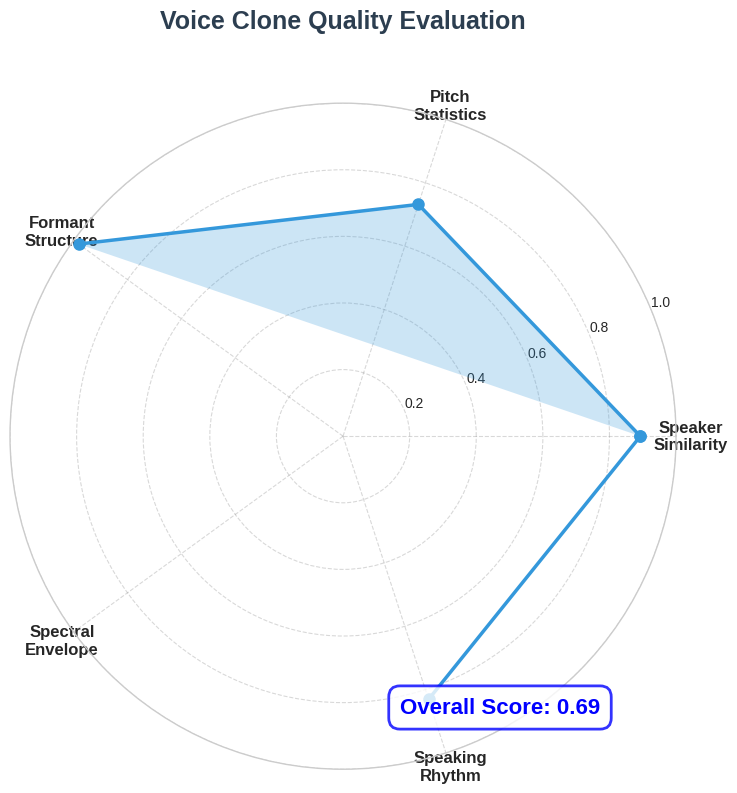

Radar chart saved to output_report_directory/radar_chart.png


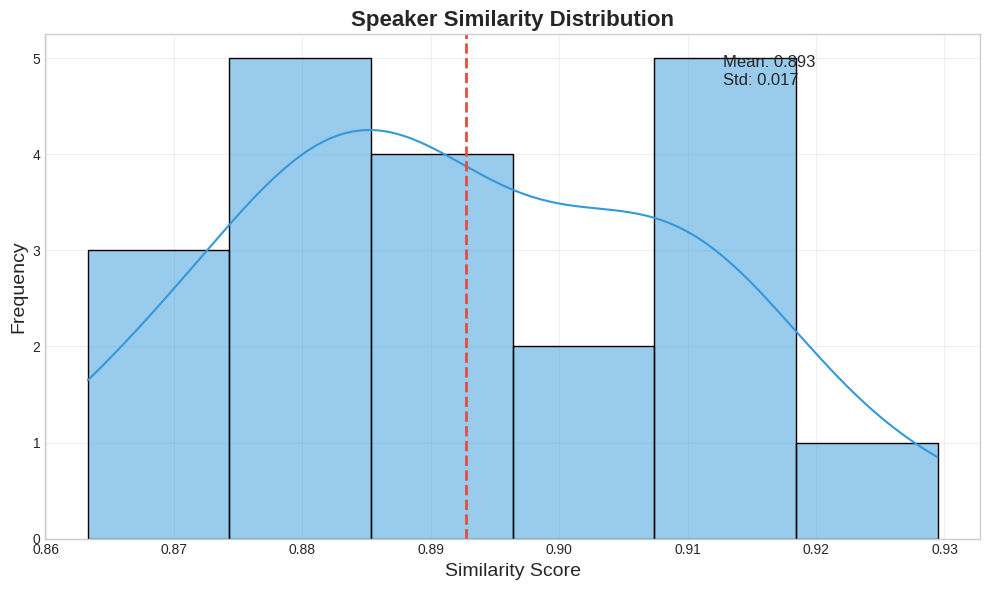

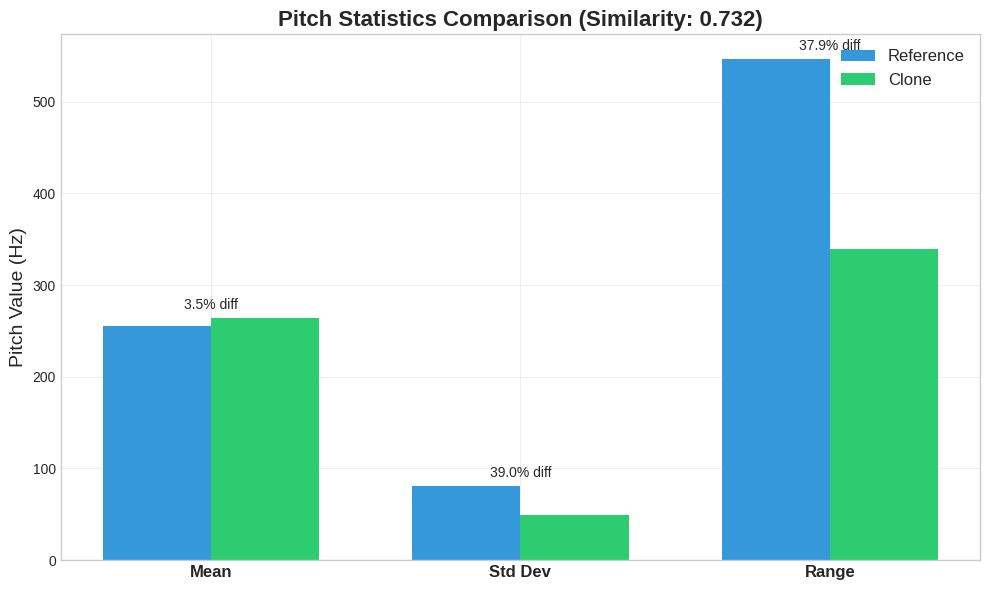

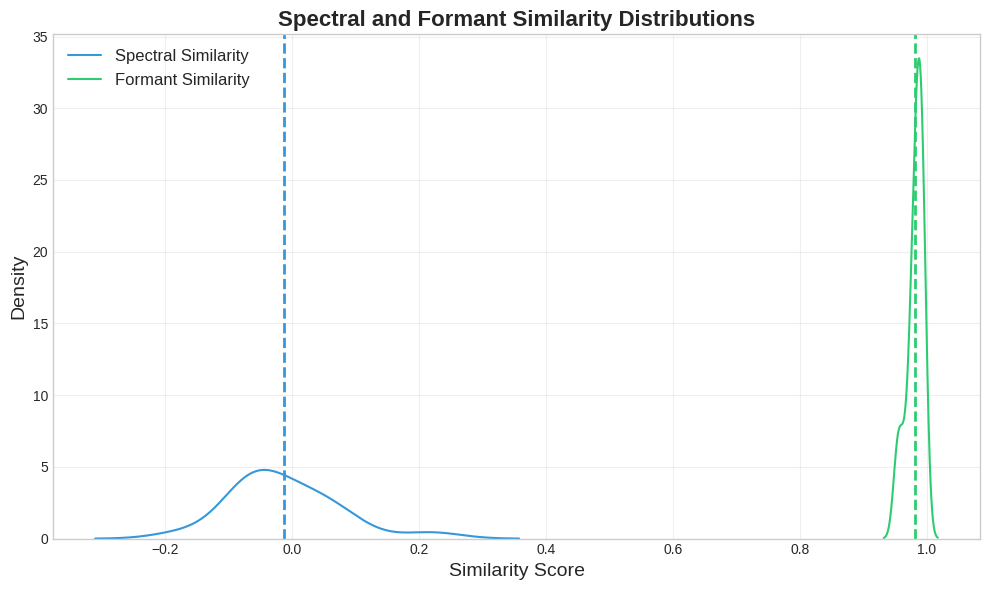

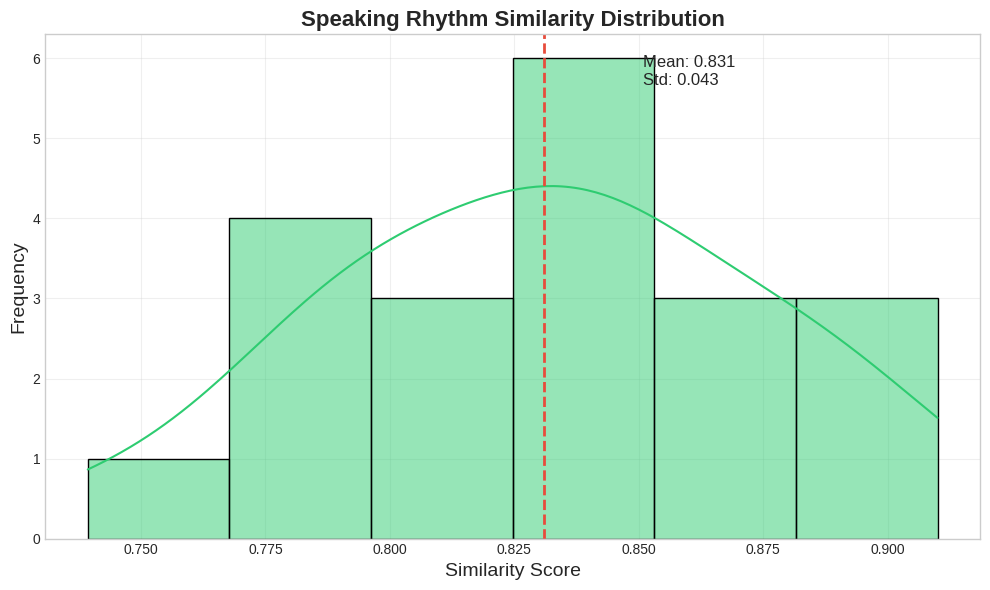

Comprehensive report generated in output_report_directory


In [9]:
import numpy as np
import librosa
import torch
import scipy
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import soundfile as sf
import gc
import warnings
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from scipy.signal import lfilter
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
import json

warnings.filterwarnings('ignore')

class EnhancedVoiceCloneEvaluator:
    def __init__(self, sample_rate=16000, device='cpu'):
        self.sr = sample_rate
        self.device = device
        self._load_speaker_encoder()
        
        plt.style.use('seaborn-v0_8-whitegrid')
        self.colors = {
            'primary': '#3498db',
            'secondary': '#2ecc71',
            'highlight': '#e74c3c',
            'background': '#f9f9f9',
            'text': '#2c3e50'
        }
        
    def _load_speaker_encoder(self):
        try:
            import torch
            
            class SpeakerEncoder(torch.nn.Module):
                def __init__(self):
                    super().__init__()
                    self.lstm = torch.nn.LSTM(
                        input_size=40,
                        hidden_size=256,
                        num_layers=3,
                        batch_first=True
                    )
                    self.linear = torch.nn.Linear(256, 256)
                    self.relu = torch.nn.ReLU()
                
                def forward(self, x):
                    _, (hidden, _) = self.lstm(x)
                    embeds = self.linear(hidden[-1])
                    embeds = self.relu(embeds)
                    embeds_norm = torch.nn.functional.normalize(embeds, p=2, dim=1)
                    return embeds_norm
            
            self.speaker_encoder = SpeakerEncoder().to(self.device)
            self.has_speaker_encoder = True
            print("Speaker encoder initialized (no pretrained weights)")
        except Exception as e:
            print(f"Speaker encoder initialization failed: {str(e)}")
            print("Using cosine similarity of spectral features instead")
            self.has_speaker_encoder = False
    
    def evaluate_voice_clone(self, reference_path, clone_path, segment_duration=5.0, num_segments=10):
        print(f"Loading reference audio: {reference_path}")
        y_ref, sr = librosa.load(reference_path, sr=self.sr)
        
        results = {}
        
        speaker_sim = self.compute_speaker_similarity(y_ref, clone_path, segment_duration, num_segments)
        results["speaker_similarity"] = speaker_sim
        print(f"Speaker similarity: {speaker_sim['mean']:.3f} ± {speaker_sim['std']:.3f}")
        
        gc.collect()
        if torch.cuda.is_available() and self.device == "cuda":
            torch.cuda.empty_cache()
            
        pitch_stats = self.compare_pitch_statistics(y_ref, clone_path, segment_duration, num_segments)
        results["pitch_statistics"] = pitch_stats
        print(f"Pitch similarity: {pitch_stats['similarity']:.3f}")
        
        gc.collect()
        
        formant_sim = self.compare_formant_structure(y_ref, clone_path, segment_duration, num_segments)
        results["formant_similarity"] = formant_sim
        print(f"Formant similarity: {formant_sim['mean']:.3f} ± {formant_sim['std']:.3f}")
        
        gc.collect()
        
        spectral_sim = self.compare_spectral_envelope(y_ref, clone_path, segment_duration, num_segments)
        results["spectral_similarity"] = spectral_sim
        print(f"Spectral similarity: {spectral_sim['mean']:.3f} ± {spectral_sim['std']:.3f}")
        
        gc.collect()
        
        rhythm_sim = self.compare_speaking_rhythm(y_ref, clone_path, segment_duration, num_segments)
        results["rhythm_similarity"] = rhythm_sim
        print(f"Rhythm similarity: {rhythm_sim['mean']:.3f} ± {rhythm_sim['std']:.3f}")
        
        overall_score = (
            0.30 * results["speaker_similarity"]["mean"] +
            0.20 * results["pitch_statistics"]["similarity"] +
            0.20 * results["formant_similarity"]["mean"] +
            0.20 * results["spectral_similarity"]["mean"] +
            0.10 * results["rhythm_similarity"]["mean"]
        )
        
        results["overall_score"] = overall_score
        print(f"Overall score: {overall_score:.3f}/1.0")
        
        results["metadata"] = {
            "reference_path": reference_path,
            "clone_path": clone_path,
            "evaluation_timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "segment_duration": segment_duration,
            "num_segments": num_segments
        }
        
        return results
    
    def compute_speaker_similarity(self, y_ref, clone_path, segment_duration=5.0, num_segments=10):
        segment_samples = int(segment_duration * self.sr)
        
        ref_melspecs = []
        for i in range(0, len(y_ref), segment_samples):
            if i + segment_samples > len(y_ref):
                continue
            
            ref_segment = y_ref[i:i + segment_samples]
            if len(ref_segment) < 0.5 * segment_samples:
                continue
                
            mel_spec = librosa.feature.melspectrogram(
                y=ref_segment, 
                sr=self.sr,
                n_mels=40,
                n_fft=1024,
                hop_length=512
            )
            log_mel = librosa.power_to_db(mel_spec)
            ref_melspecs.append(log_mel)
        
        if not ref_melspecs:
            return {"mean": 0.0, "std": 0.0, "scores": []}
        
        ref_avg_melspec = np.mean(ref_melspecs, axis=0)
        
        similarities = []
        
        with sf.SoundFile(clone_path) as f:
            clone_sr = f.samplerate
            clone_segment_samples = int(segment_duration * clone_sr)
            
            total_frames = f.frames
            if total_frames < clone_segment_samples:
                segment_indices = [0]
            else:
                segment_indices = np.linspace(
                    0, 
                    total_frames - clone_segment_samples, 
                    min(num_segments, total_frames // clone_segment_samples),
                    dtype=int
                )
            
            for idx in segment_indices:
                f.seek(idx)
                clone_segment = f.read(clone_segment_samples, dtype='float32')
                
                if clone_segment.ndim > 1:
                    clone_segment = clone_segment.mean(axis=1)
                
                if clone_sr != self.sr:
                    clone_segment = librosa.resample(clone_segment, orig_sr=clone_sr, target_sr=self.sr)
                
                clone_mel = librosa.feature.melspectrogram(
                    y=clone_segment, 
                    sr=self.sr,
                    n_mels=40,
                    n_fft=1024,
                    hop_length=512
                )
                clone_log_mel = librosa.power_to_db(clone_mel)
                
                ref_flat = ref_avg_melspec.flatten()
                clone_flat = clone_log_mel.flatten()
                
                min_len = min(len(ref_flat), len(clone_flat))
                similarity = 1 - cosine(ref_flat[:min_len], clone_flat[:min_len])
                similarities.append(similarity)
        
        if not similarities:
            return {"mean": 0.0, "std": 0.0, "scores": []}
            
        return {
            "mean": float(np.mean(similarities)),
            "std": float(np.std(similarities)),
            "scores": [float(s) for s in similarities]
        }
    
    def _extract_pitch(self, y):
        try:
            f0, voiced_flag, _ = librosa.pyin(
                y,
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C7'),
                sr=self.sr
            )
            
            if voiced_flag is not None:
                return f0[voiced_flag]
            return None
        except Exception as e:
            print(f"Pitch extraction failed: {str(e)}")
            return None
    
    def compare_pitch_statistics(self, y_ref, clone_path, segment_duration=5.0, num_segments=10):
        ref_pitch = self._extract_pitch(y_ref)
        
        if ref_pitch is None or len(ref_pitch) == 0:
            return {
                "similarity": 0.0,
                "reference": {"mean": 0, "std": 0, "range": 0},
                "clone": {"mean": 0, "std": 0, "range": 0}
            }
        
        ref_pitch_mean = np.mean(ref_pitch)
        ref_pitch_std = np.std(ref_pitch)
        ref_pitch_range = np.ptp(ref_pitch)
        
        clone_pitches = []
        
        with sf.SoundFile(clone_path) as f:
            clone_sr = f.samplerate
            clone_segment_samples = int(segment_duration * clone_sr)
            
            total_frames = f.frames
            if total_frames < clone_segment_samples:
                segment_indices = [0]
            else:
                segment_indices = np.linspace(
                    0, 
                    total_frames - clone_segment_samples, 
                    min(num_segments, total_frames // clone_segment_samples),
                    dtype=int
                )
            
            for idx in segment_indices:
                f.seek(idx)
                clone_segment = f.read(clone_segment_samples, dtype='float32')
                
                if clone_segment.ndim > 1:
                    clone_segment = clone_segment.mean(axis=1)
                
                if clone_sr != self.sr:
                    clone_segment = librosa.resample(clone_segment, orig_sr=clone_sr, target_sr=self.sr)
                
                clone_pitch = self._extract_pitch(clone_segment)
                if clone_pitch is not None and len(clone_pitch) > 0:
                    clone_pitches.extend(clone_pitch)
        
        if not clone_pitches:
            return {
                "similarity": 0.0,
                "reference": {"mean": float(ref_pitch_mean), "std": float(ref_pitch_std), "range": float(ref_pitch_range)},
                "clone": {"mean": 0, "std": 0, "range": 0}
            }
        
        clone_pitch_mean = np.mean(clone_pitches)
        clone_pitch_std = np.std(clone_pitches)
        clone_pitch_range = np.ptp(clone_pitches)
        
        mean_diff = abs(ref_pitch_mean - clone_pitch_mean) / max(ref_pitch_mean, 1e-5)
        std_diff = abs(ref_pitch_std - clone_pitch_std) / max(ref_pitch_std, 1e-5)
        range_diff = abs(ref_pitch_range - clone_pitch_range) / max(ref_pitch_range, 1e-5)
        
        similarity = 1.0 - np.mean([mean_diff, std_diff, range_diff])
        similarity = max(0.0, min(1.0, similarity))
        
        return {
            "similarity": float(similarity),
            "reference": {
                "mean": float(ref_pitch_mean), 
                "std": float(ref_pitch_std), 
                "range": float(ref_pitch_range)
            },
            "clone": {
                "mean": float(clone_pitch_mean), 
                "std": float(clone_pitch_std), 
                "range": float(clone_pitch_range)
            }
        }
    
    def _extract_formants(self, y):
        try:
            y_pre = np.append(y[0], y[1:] - 0.97 * y[:-1])
            y_win = y_pre * np.hanning(len(y_pre))
            n_formants = 4
            order = 2 + self.sr // 1000
            
            if np.isnan(y_win).any() or np.isinf(y_win).any() or np.max(np.abs(y_win)) < 1e-6:
                return None
                
            lpc_coeffs = librosa.lpc(y_win, order=order)
            roots = np.polynomial.polynomial.polyroots(np.flip(lpc_coeffs))
            roots = roots[np.imag(roots) > 0]
            
            magnitudes = np.abs(roots)
            roots = roots[(magnitudes > 0.7) & (magnitudes < 0.99)]
            
            angles = np.abs(np.angle(roots))
            formants = angles * self.sr / (2 * np.pi)
            
            formants = np.sort(formants)
            if len(formants) >= n_formants:
                return formants[:n_formants]
            else:
                return np.pad(formants, (0, n_formants - len(formants)))
        except Exception as e:
            print(f"Formant extraction failed: {str(e)}")
            return None
    
    def _compare_formant_distributions(self, formants_ref, formants_clone):
        try:
            formants_ref_norm = formants_ref / np.mean(formants_ref) if np.mean(formants_ref) > 0 else formants_ref
            formants_clone_norm = formants_clone / np.mean(formants_clone) if np.mean(formants_clone) > 0 else formants_clone
            
            mse = mean_squared_error(formants_ref_norm, formants_clone_norm)
            similarity = np.exp(-mse)
            
            return min(1.0, max(0.0, similarity))
        except Exception as e:
            print(f"Formant comparison failed: {str(e)}")
            return 0.0
    
    def compare_formant_structure(self, y_ref, clone_path, segment_duration=5.0, num_segments=10):
        ref_formants = self._extract_formants(y_ref)
        
        if ref_formants is None:
            return {"mean": 0.0, "std": 0.0, "scores": []}
        
        formant_similarities = []
        
        with sf.SoundFile(clone_path) as f:
            clone_sr = f.samplerate
            clone_segment_samples = int(segment_duration * clone_sr)
            
            total_frames = f.frames
            if total_frames < clone_segment_samples:
                segment_indices = [0]
            else:
                segment_indices = np.linspace(
                    0, 
                    total_frames - clone_segment_samples, 
                    min(num_segments, total_frames // clone_segment_samples),
                    dtype=int
                )
            
            for idx in segment_indices:
                f.seek(idx)
                clone_segment = f.read(clone_segment_samples, dtype='float32')
                
                if clone_segment.ndim > 1:
                    clone_segment = clone_segment.mean(axis=1)
                
                if clone_sr != self.sr:
                    clone_segment = librosa.resample(clone_segment, orig_sr=clone_sr, target_sr=self.sr)
                
                clone_formants = self._extract_formants(clone_segment)
                
                if clone_formants is not None:
                    similarity = self._compare_formant_distributions(ref_formants, clone_formants)
                    formant_similarities.append(similarity)
        
        if not formant_similarities:
            return {"mean": 0.0, "std": 0.0, "scores": []}
            
        return {
            "mean": float(np.mean(formant_similarities)),
            "std": float(np.std(formant_similarities)),
            "scores": [float(s) for s in formant_similarities]
        }
    
    def compare_spectral_envelope(self, y_ref, clone_path, segment_duration=5.0, num_segments=10):
        ref_specs = []
        segment_samples = int(segment_duration * self.sr)
        
        for i in range(0, len(y_ref), segment_samples):
            if i + segment_samples > len(y_ref):
                continue
                
            ref_segment = y_ref[i:i + segment_samples]
            
            cent = librosa.feature.spectral_centroid(y=ref_segment, sr=self.sr)[0]
            bw = librosa.feature.spectral_bandwidth(y=ref_segment, sr=self.sr)[0]
            flatness = librosa.feature.spectral_flatness(y=ref_segment)[0]
            
            features = np.vstack([cent, bw, flatness])
            ref_specs.append(features)
        
        if not ref_specs:
            return {"mean": 0.0, "std": 0.0, "scores": []}
            
        ref_avg_spec = np.mean(ref_specs, axis=0)
        
        spectral_similarities = []
        
        with sf.SoundFile(clone_path) as f:
            clone_sr = f.samplerate
            clone_segment_samples = int(segment_duration * clone_sr)
            
            total_frames = f.frames
            if total_frames < clone_segment_samples:
                segment_indices = [0]
            else:
                segment_indices = np.linspace(
                    0, 
                    total_frames - clone_segment_samples, 
                    min(num_segments, total_frames // clone_segment_samples),
                    dtype=int
                )
            
            for idx in segment_indices:
                f.seek(idx)
                clone_segment = f.read(clone_segment_samples, dtype='float32')
                
                if clone_segment.ndim > 1:
                    clone_segment = clone_segment.mean(axis=1)
                
                if clone_sr != self.sr:
                    clone_segment = librosa.resample(clone_segment, orig_sr=clone_sr, target_sr=self.sr)
                
                cent = librosa.feature.spectral_centroid(y=clone_segment, sr=self.sr)[0]
                bw = librosa.feature.spectral_bandwidth(y=clone_segment, sr=self.sr)[0]
                flatness = librosa.feature.spectral_flatness(y=clone_segment)[0]
                
                features = np.vstack([cent, bw, flatness])
                
                min_len = min(ref_avg_spec.shape[1], features.shape[1])
                
                scaler = StandardScaler()
                ref_features_norm = scaler.fit_transform(ref_avg_spec[:, :min_len].T).T
                clone_features_norm = scaler.transform(features[:, :min_len].T).T
                
                similarity = 0
                for i in range(ref_features_norm.shape[0]):
                    similarity += 1 - cosine(ref_features_norm[i], clone_features_norm[i])
                
                similarity /= ref_features_norm.shape[0]
                spectral_similarities.append(similarity)
        
        if not spectral_similarities:
            return {"mean": 0.0, "std": 0.0, "scores": []}
            
        return {
            "mean": float(np.mean(spectral_similarities)),
            "std": float(np.std(spectral_similarities)),
            "scores": [float(s) for s in spectral_similarities]
        }
        
    def _extract_rhythm_features(self, y):
        try:
            onset_env = librosa.onset.onset_strength(y=y, sr=self.sr)
            
            tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=self.sr)[0]
            
            ac = librosa.autocorrelate(onset_env, max_size=self.sr // 2)
            ac = ac / ac[0]
            pulse_clarity = np.max(ac[1:])
            
            energy = librosa.feature.rms(y=y)[0]
            energy_mean = np.mean(energy)
            energy_std = np.std(energy)
            
            return {
                "tempo": tempo,
                "pulse_clarity": pulse_clarity,
                "energy_mean": energy_mean,
                "energy_std": energy_std
            }
        except Exception as e:
            print(f"Rhythm feature extraction failed: {str(e)}")
            return None
    
    def _compare_rhythm_features(self, rhythm_ref, rhythm_clone):
        try:
            tempo_diff = abs(rhythm_ref["tempo"] - rhythm_clone["tempo"]) / max(rhythm_ref["tempo"], 1e-5)
            pulse_diff = abs(rhythm_ref["pulse_clarity"] - rhythm_clone["pulse_clarity"]) / max(rhythm_ref["pulse_clarity"], 1e-5)
            energy_mean_diff = abs(rhythm_ref["energy_mean"] - rhythm_clone["energy_mean"]) / max(rhythm_ref["energy_mean"], 1e-5)
            energy_std_diff = abs(rhythm_ref["energy_std"] - rhythm_clone["energy_std"]) / max(rhythm_ref["energy_std"], 1e-5)
            
            diffs = [tempo_diff, pulse_diff, energy_mean_diff, energy_std_diff]
            similarity = 1.0 - np.mean(diffs)
            
            return max(0.0, min(1.0, similarity))
        except Exception as e:
            print(f"Rhythm comparison failed: {str(e)}")
            return 0.0
    
    def compare_speaking_rhythm(self, y_ref, clone_path, segment_duration=5.0, num_segments=10):
        ref_rhythm = self._extract_rhythm_features(y_ref)
        
        if ref_rhythm is None:
            return {"mean": 0.0, "std": 0.0, "scores": []}
        
        rhythm_similarities = []
        
        with sf.SoundFile(clone_path) as f:
            clone_sr = f.samplerate
            clone_segment_samples = int(segment_duration * clone_sr)
            
            total_frames = f.frames
            if total_frames < clone_segment_samples:
                segment_indices = [0]
            else:
                segment_indices = np.linspace(
                    0, 
                    total_frames - clone_segment_samples, 
                    min(num_segments, total_frames // clone_segment_samples),
                    dtype=int
                )
            
            for idx in segment_indices:
                f.seek(idx)
                clone_segment = f.read(clone_segment_samples, dtype='float32')
                
                if clone_segment.ndim > 1:
                    clone_segment = clone_segment.mean(axis=1)
                
                if clone_sr != self.sr:
                    clone_segment = librosa.resample(clone_segment, orig_sr=clone_sr, target_sr=self.sr)
                
                clone_rhythm = self._extract_rhythm_features(clone_segment)
                
                if clone_rhythm is not None:
                    similarity = self._compare_rhythm_features(ref_rhythm, clone_rhythm)
                    rhythm_similarities.append(similarity)
        
        if not rhythm_similarities:
            return {"mean": 0.0, "std": 0.0, "scores": []}
            
        return {
            "mean": float(np.mean(rhythm_similarities)),
            "std": float(np.std(rhythm_similarities)),
            "scores": [float(s) for s in rhythm_similarities]
        }
    
    def _get_score_color(self, score):
        if score >= 0.8:
            return 'green'
        elif score >= 0.6:
            return 'blue'
        elif score >= 0.4:
            return 'orange'
        else:
            return 'red'
    
    def plot_radar_chart(self, results, output_path):
        categories = [
            'Speaker\nSimilarity', 
            'Pitch\nStatistics', 
            'Formant\nStructure',
            'Spectral\nEnvelope', 
            'Speaking\nRhythm'
        ]
        
        values = [
            results["speaker_similarity"]["mean"],
            results["pitch_statistics"]["similarity"],
            results["formant_similarity"]["mean"],
            results["spectral_similarity"]["mean"],
            results["rhythm_similarity"]["mean"]
        ]
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, polar=True)
        
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
        values_plot = values + [values[0]]
        angles_plot = angles + [angles[0]]
        
        ax.grid(color='gray', alpha=0.3, linestyle='--')
        
        ax.plot(angles_plot, values_plot, 'o-', linewidth=2.5, color=self.colors['primary'], markersize=8)
        ax.fill(angles_plot, values_plot, alpha=0.25, color=self.colors['primary'])
        
        ax.set_thetagrids(np.degrees(angles), categories, fontsize=12, fontweight='bold')
        
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
        
        overall_score = results["overall_score"]
        score_color = self._get_score_color(overall_score)
        
        plt.annotate(
            f'Overall Score: {overall_score:.2f}',
            xy=(0.5, 0.1),
            xycoords='figure fraction',
            ha='center',
            fontsize=16,
            fontweight='bold',
            color=score_color,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec=score_color, linewidth=2, alpha=0.8)
        )
        
        plt.title('Voice Clone Quality Evaluation', size=18, y=1.1, fontweight='bold', color=self.colors['text'])
        plt.tight_layout()
        
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Radar chart saved to {output_path}")
        plt.close()
    
    def _plot_speaker_similarity(self, results, output_path):
        plt.figure(figsize=(10, 6))
        
        scores = results["speaker_similarity"]["scores"]
        mean = results["speaker_similarity"]["mean"]
        std = results["speaker_similarity"]["std"]
        
        sns.histplot(scores, kde=True, color=self.colors['primary'])
        
        plt.axvline(mean, color=self.colors['highlight'], linestyle='--', linewidth=2)
        plt.text(
            mean + 0.02, 
            plt.ylim()[1] * 0.9, 
            f"Mean: {mean:.3f}\nStd: {std:.3f}", 
            fontsize=12
        )
        
        plt.title("Speaker Similarity Distribution", fontsize=16, fontweight='bold')
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    def _plot_pitch_comparison(self, results, output_path):
        ref_stats = results["pitch_statistics"]["reference"]
        clone_stats = results["pitch_statistics"]["clone"]
        similarity = results["pitch_statistics"]["similarity"]
        
        labels = ['Mean', 'Std Dev', 'Range']
        ref_values = [ref_stats['mean'], ref_stats['std'], ref_stats['range']]
        clone_values = [clone_stats['mean'], clone_stats['std'], clone_stats['range']]
        
        x = np.arange(len(labels))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(x - width/2, ref_values, width, label='Reference', color=self.colors['primary'])
        ax.bar(x + width/2, clone_values, width, label='Clone', color=self.colors['secondary'])
        
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
        ax.set_ylabel('Pitch Value (Hz)', fontsize=14)
        ax.set_title(f'Pitch Statistics Comparison (Similarity: {similarity:.3f})', fontsize=16, fontweight='bold')
        ax.legend(fontsize=12)
        ax.grid(True, alpha=0.3)
        
        for i in range(len(labels)):
            percent_diff = abs(ref_values[i] - clone_values[i]) / max(ref_values[i], 1e-5) * 100
            ax.annotate(
                f"{percent_diff:.1f}% diff", 
                xy=(x[i], max(ref_values[i], clone_values[i]) + 10),
                ha='center',
                fontsize=10
            )
        
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
        
    def _plot_spectral_comparison(self, results, output_path):
        plt.figure(figsize=(10, 6))
        
        scores = results["spectral_similarity"]["scores"]
        formant_scores = results["formant_similarity"]["scores"]
        
        sns.kdeplot(scores, label="Spectral Similarity", color=self.colors['primary'])
        sns.kdeplot(formant_scores, label="Formant Similarity", color=self.colors['secondary'])
        
        plt.axvline(
            results["spectral_similarity"]["mean"], 
            color=self.colors['primary'], 
            linestyle='--', 
            linewidth=2
        )
        plt.axvline(
            results["formant_similarity"]["mean"], 
            color=self.colors['secondary'], 
            linestyle='--', 
            linewidth=2
        )
        
        plt.title("Spectral and Formant Similarity Distributions", fontsize=16, fontweight='bold')
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Density", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    
    def _plot_rhythm_comparison(self, results, output_path):
        plt.figure(figsize=(10, 6))
        
        scores = results["rhythm_similarity"]["scores"]
        mean = results["rhythm_similarity"]["mean"]
        std = results["rhythm_similarity"]["std"]
        
        sns.histplot(scores, kde=True, color=self.colors['secondary'])
        
        plt.axvline(mean, color=self.colors['highlight'], linestyle='--', linewidth=2)
        plt.text(
            mean + 0.02, 
            plt.ylim()[1] * 0.9, 
            f"Mean: {mean:.3f}\nStd: {std:.3f}", 
            fontsize=12
        )
        
        plt.title("Speaking Rhythm Similarity Distribution", fontsize=16, fontweight='bold')
        plt.xlabel("Similarity Score", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()
    
    def generate_comprehensive_report(self, results, output_dir):
        """Generate a comprehensive report with all visualizations."""
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate summary plot
        radar_path = os.path.join(output_dir, "radar_chart.png")
        self.plot_radar_chart(results, radar_path)
        
        # Generate individual plots
        speaker_path = os.path.join(output_dir, "speaker_similarity.png")
        pitch_path = os.path.join(output_dir, "pitch_comparison.png")
        spectral_path = os.path.join(output_dir, "spectral_comparison.png")
        rhythm_path = os.path.join(output_dir, "rhythm_comparison.png")
        
        self._plot_speaker_similarity(results, speaker_path)
        self._plot_pitch_comparison(results, pitch_path)
        self._plot_spectral_comparison(results, spectral_path)
        self._plot_rhythm_comparison(results, rhythm_path)
        
        # Save results to JSON
        results_path = os.path.join(output_dir, "evaluation_results.json")
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=4)
        
        print(f"Comprehensive report generated in {output_dir}")
        
        return {
            "radar_chart": radar_path,
            "speaker_similarity": speaker_path,
            "pitch_comparison": pitch_path,
            "spectral_comparison": spectral_path,
            "rhythm_comparison": rhythm_path,
            "results_json": results_path
        }
    

evaluator = EnhancedVoiceCloneEvaluator(sample_rate=16000, device='cuda')

reference_audio = "/kaggle/working/long_wavs/1.wav"
clone_audio = "/kaggle/working/output/final_output_combined.wav"

results = evaluator.evaluate_voice_clone(
    reference_path=reference_audio,
    clone_path=clone_audio,
    segment_duration=5.0,  
    num_segments=20        
)

report_paths = evaluator.generate_comprehensive_report(results, "output_report_directory")